In [1]:
#!/usr/bin/env python;
# coding: utf-8

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "" # Delete above if you want to use GPU
import tensorflow as tf
import keras
from keras.layers import Softmax,Input,TimeDistributed,Dense,Average,GlobalAveragePooling1D,Concatenate,Lambda,RepeatVector
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pylab as pl
from IPython import display
from IPython.core.display import HTML
from IPython.core.display import display as html_width
import tensorflow_probability as tfp
html_width(HTML("<style>.container { width:90% !important; }</style>"))

## Generating example demonstration:<br>
These demonstrations are used in the first experiment of the <b>Conditional Neural Movement Primitives (RSS 2019) by Yunus Seker, Mert Imre, Justus Piater and Emre Ugur</b><br>
<br>
This experiment does not involve external parameters.

In [3]:
def dist_generator(d, x, param, noise = 0):
    f = (math.exp(-x**2/(2.*param[0]**2))/(math.sqrt(2*math.pi)*param[0]))+param[1]
    return f+(noise*(np.random.rand()-0.5)/100.)

In [4]:
def generate_demonstrations(time_len = 200, params = None, title = None):
    fig = plt.figure(figsize=(5,5))
    x = np.linspace(-0.5,0.5,time_len)
    times = np.zeros((params.shape[0],time_len,1))
    times[:] = x.reshape((1,time_len,1))+0.5
    values = np.zeros((params.shape[0],time_len,1))
    for d in range(params.shape[0]):
            for i in range(time_len):
                values[d,i] = dist_generator(d,x[i],params[d])
            plt.plot(times[d], values[d])
    plt.title(title+' Demonstrations')
    plt.ylabel('Starting Position')
    plt.show()
    return times, values

In [5]:
def interpolateJointData(trajectory, num_of_steps_expected):
    return np.append(trajectory, np.tile(trajectory[-1], ((num_of_steps_expected - len(trajectory)), 1)))

## Loading model inputs<br>
<b>Input Requirements</b>:<br>
<br>
* <b>obs_max</b>: Hyperparameter that decides to the maximum number of observations CNMP uses. In this experiment, it is set to 5<br>
* <b>d_N</b>: Number of demonstrations (in our case, 5)<br>
<br>
* <b>d_x</b>: X vector feature dim (NOTE THAT: external parameters are assumed to be inside of the X vector, concatenated to time value. In this experiment we have additional dimension as final position x-y pixel coordinate of the object so an additional 2 dimensions will be added along with time which will yield d_x = 3)<br>
<br>
* <b>d_y</b>: Y vector feature dim (In this experiment, we have 8 joints' data per arm as Y which yields d_Y = 16)<br>
<br>
* <b>time_len</b>: length of the demonstrations, if all demonstrations does not have same length, use array and edit methods using time_len, or preprocess your data to interpolate into same time length (custom function used to extend the trajectory called interpolateJointData(trajectory, num_of_steps_expected))<br>
<br>
* <b>X</b>: shape=(d_N,time_len,d_x) --- time (and external parameter) values for each timestep for ith demonstration. d_x = 1+d_external_parameters<br>
<br>
* <b>Y</b>: shape=(d_N,time_len,d_y) --- corresponding values of f(X) for ith demonstration<br>
<br>
* <b>obs_mlp_layers</b>: Hidden neuron numbers of the dense layers inside of the Observation multi layer perceptron. Layer numbers can adapt to the list size. Last layer is always Linear, others are ReLU activated.<br>
<br>
* <b>decoder_layers</b>: Hidden neuron numbers of the dense layers inside of the Decoder multi layer perceptron. Layer numbers can adapt to the list size. Last layer size is always 2*d_y and activation is Linear, others are ReLU activated.

Loading demonstrations and necessary variables

In [6]:
Y= np.array([np.genfromtxt('./liquid_pour_train_data/salimdemet1_0.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet1_1.csv', delimiter=',')[1:,1:], 
             np.genfromtxt('./liquid_pour_train_data/salimdemet1_2.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet1_3.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./liquid_pour_train_data/salimdemet1_4.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet2_0.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./liquid_pour_train_data/salimdemet2_1.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet1_2.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./liquid_pour_train_data/salimdemet2_3.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet2_4.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./liquid_pour_train_data/salimdemet3_0.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet3_1.csv', delimiter=',')[1:,1:], 
             np.genfromtxt('./liquid_pour_train_data/salimdemet3_2.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet3_3.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./liquid_pour_train_data/salimdemet3_4.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet4_0.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./liquid_pour_train_data/salimdemet4_1.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet4_2.csv', delimiter=',')[1:,1:],
             np.genfromtxt('./liquid_pour_train_data/salimdemet4_3.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet4_4.csv', delimiter=',')[1:,1:]], dtype=object)


v_Y = np.array([np.genfromtxt('./liquid_pour_train_data/salimdemet5_0.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet5_1.csv', delimiter=',')[1:,1:], 
                np.genfromtxt('./liquid_pour_train_data/salimdemet5_2.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet5_3.csv', delimiter=',')[1:,1:],
                np.genfromtxt('./liquid_pour_train_data/salimdemet5_4.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet6_0.csv', delimiter=',')[1:,1:],
                np.genfromtxt('./liquid_pour_train_data/salimdemet6_1.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet6_2.csv', delimiter=',')[1:,1:],
                np.genfromtxt('./liquid_pour_train_data/salimdemet6_3.csv', delimiter=',')[1:,1:], np.genfromtxt('./liquid_pour_train_data/salimdemet6_4.csv', delimiter=',')[1:,1:]], dtype=object)

length1 = len(max(Y, key=len))
length2 = len(max(v_Y, key=len))
length = max([length1,length2])

time_array = np.linspace(0.5, 0.5 + (length-1)*0.01, length)

gamma = [[43.1,20.2], [33.6,9.6], [33.3,32.0], [54.9,32.5], [55.3,9.2], [66.2,22.4]]

X = np.array([], dtype=object)
for i in range(0,20): #gamma is a list type, not numpy array
    e = gamma[i//5]
    x_axis = np.array([np.array([t]+e, dtype=np.float32) for t in time_array], dtype=np.float32)
    X = np.append(X, x_axis)
    
    
v_X = np.array([])
for i in range(0,10): #gamma is a list type, not numpy array
    e = gamma[i//5]
    x_axis = np.array([np.array([t]+ e, dtype=np.float32) for t in time_array], dtype=np.float32)
    v_X = np.append(v_X, x_axis)



In [7]:
Y = np.array([interpolateJointData(element, length) for element in Y])
Y = Y.reshape(20,length,16)

In [9]:
v_X = v_X.reshape(10,length,3)
X = X.reshape(20, length, 3)

In [10]:
v_Y = np.array([interpolateJointData(element, length) for element in v_Y])
v_Y = v_Y.reshape(10,length, 16)

In [11]:
obs_max = 15  
d_N = X.shape[0] 
d_x , d_y = (X.shape[-1] , Y.shape[-1])

In [12]:
time_len = X.shape[1] 
obs_mlp_layers = [128,128,128]
decoder_layers = [128,128,d_y*2]

In [13]:
print('d_N=', d_N)
print('obs_max=', obs_max)
print('X',X.shape,', Y',Y.shape)
print('d_x=',d_x)
print('d_y=',d_y)
print('time_len=', time_len) 

print("d_vx: ", v_X.shape)
print("d_vy: ", v_Y.shape)

d_N= 20
obs_max= 15
X (20, 7074, 3) , Y (20, 7074, 16)
d_x= 3
d_y= 16
time_len= 7074
d_vx:  (10, 7074, 3)
d_vy:  (10, 7074, 16)


# Conditional Neural Movement Primitives

### <b>get_train_sample()</b>: <br>
* Selects a random observation number, n<br>
* Selects a random demonstration id, d<br>
* Permutes demonstration d, so the first n data can be observation. Selects (n+1)th data to be the target point<br>
* Returns observations and target_X as inputs to the model to predict target_Y

In [14]:
def get_train_sample():
    n = np.random.randint(0,obs_max)+1
    d = np.random.randint(0, d_N)
    observation = np.zeros((1,n,d_x+d_y)) 
    target_X = np.zeros((1,1,d_x))
    target_Y = np.zeros((1,1,d_y*2))
    perm = np.random.permutation(time_len)
    observation[0,:n,:d_x] = X[d,perm[:n]]
    observation[0,:n,d_x:d_x+d_y] = Y[d,perm[:n]]
    target_X[0,0] = X[d,perm[n]]
    target_Y[0,0,:d_y] = Y[d,perm[n]]
    return [observation,target_X], target_Y

### <b>predict_model()</b>: <br>
* Predicts whole trajectory according to the given observation batch<br>
* <b>observation</b>: observation points as a batch. <br>
  * Dimension must be -> (1, obs_n, d_x+d_y) where obs_n is the number of observations for this prediction<br>
* <b>target_X</b>: target X points as a batch. Model can predict one, multi, partial or whole trajectory/points as long as input is shaped as a batch<br>
  * Dimension must be -> (1, target_n, d_x) where target_n is the number of points to predict<br>
  * For whole trajectory give all X points through time length as a batch (for ex. the first demonstration = X[0].reshape=(1,time_len,d_x) <br>
* <b>prediction</b>: Output that holds predicted means and standart deviations for each time point in the X. Later splitted into <b>predicted_Y</b> and <b>predicted_std</b><br>
* <b>plot</b>: if True, plots demonstrations and predicted distribution<br>
* Returns predicted means and stds

In[27]:

In [15]:
def predict_model(observation, target_X, plot = True):
    predicted_Y = np.zeros((time_len,d_y))
    predicted_std = np.zeros((time_len,d_y))
    prediction = model.predict([observation,target_X])[0] 
    predicted_Y = prediction[:,:d_y]
    predicted_std = np.log(1+np.exp(prediction[:,d_y:]))
    if plot: # We highly recommend that you customize your own plot function, but you can use this function as default
        for i in range(d_y): #for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            for j in range(d_N):
                plt.plot(X[j,:,0],Y[j,:,i]) # assuming X[j,:,0] is time
            plt.plot(X[j,:,0],predicted_Y[:,i],color='black')
            plt.errorbar(X[j,:,0],predicted_Y[:,i],yerr=predicted_std[:,i],color = 'black',alpha=0.4)
            plt.scatter(observation[0,:,0],observation[0,:,d_x+i],marker="X",color='black')
            plt.show()  
    return predicted_Y, predicted_std

### custom_loss():<br>
* Calculates log probability of the true value of the target point according to the multivariate Gaussian constructed by predicted means and stds<br>
* Returns minus of that value

In[28]:

In [16]:
def custom_loss(y_true, y_predicted):
    mean, log_sigma = tf.split(y_predicted, 2, axis=-1)
    y_true_value, temp =tf.split(y_true,2,axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_true_value))
    return loss

### MLP():<br>
<br>
* Constructs a multilayer perceptron according to the given input dimension and layer sizes.<br>
* <b>input_dim</b>: dimension of the input feature vector<br>
* <b>layers</b>: Constructs a dense layer for each number in the list. Layer numbers are flexible to list size. Except for the last layer, all layers are ReLU activated.<br>
  * ex: (2,[128,128,128]) Constructs a multi layer perceptron with each dense layer's neuron sizes correspond to (2->128->128->128) from input to output<br>
  * ex: (4,[128,4]) Constructs a multi layer perceptron with each dense layer's neuron sizes correspond to (4->128->4) from input to output<br>
* <b>parallel_input</b>:<br>
  * if <b>False</b>, MLP acts as classical fully connected MLP. Output is a single result.<br>
  * if <b>True</b>, MLP acts as a single parameter-sharing network. Every tuple in the input batch passes through MLP paralelly, independently from each other. Output is a batch which every row is the result of the corresponding tuple from the input batch passing through the parameter-sharing network.<br>
  * <b>TLDR;</b> use parallel input for encoding observations into representations, and fully connected MLP for every any other dense networks.

In[29]:

In [17]:
def MLP(input_dim, layers, name="mlp", parallel_inputs=False):
    input_layer = Input(shape=(None, input_dim),name=name+'_input')
    for i in range(len(layers)-1):
        hidden = TimeDistributed(Dense(layers[i], activation='relu'), name=name+'_'+str(i))(input_layer if i == 0 else hidden) if parallel_inputs else Dense(layers[i], activation='relu', name=name+'_'+str(i))(input_layer if i == 0 else hidden)
    hidden = TimeDistributed(Dense(layers[-1]), name=name+'_output')(hidden) if parallel_inputs else Dense(layers[-1], name=name+'_output')(hidden)
    return Model(input_layer, hidden, name=name)

## CNMP model:

<p><br>
As proposed in the paper, the model is created. Layers can be tracked from figure below:<br>
<br><br>
<img src="CNP.png" width=500 align="left"><br>
</p>

In[30]:

In [18]:
observation_layer = Input(shape=(None,d_x+d_y), name="observation") # (x_o,y_o) tuples
target_X_layer = Input(shape=(None,d_x), name="target") # x_q

In [19]:
ObsMLP = MLP(d_x+d_y, obs_mlp_layers, name='obs_mlp', parallel_inputs=True) # Network E
obs_representations = ObsMLP(observation_layer) # r_i
general_representation = GlobalAveragePooling1D()(obs_representations) # r
general_representation = Lambda(lambda x: tf.keras.backend.repeat(x[0],tf.shape(x[1])[1]), name='Repeat')([general_representation,target_X_layer]) # r in batch form (same)

In [20]:
merged_layer = Concatenate(axis=2, name='merged')([general_representation,target_X_layer]) # (r,x_q) tuple
Decoder = MLP(d_x+obs_mlp_layers[-1], decoder_layers, name = 'decoder_mlp', parallel_inputs=False) # Network Q
output = Decoder(merged_layer) # (mean_q, std_q)

In [21]:
model = Model([observation_layer, target_X_layer],output)
model.compile(optimizer = Adam(learning_rate= 1e-4),loss=custom_loss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observation (InputLayer)       [(None, None, 19)]   0           []                               
                                                                                                  
 obs_mlp (Functional)           (None, None, 128)    35584       ['observation[0][0]']            
                                                                                                  
 global_average_pooling1d (Glob  (None, 128)         0           ['obs_mlp[0][0]']                
 alAveragePooling1D)                                                                              
                                                                                                  
 target (InputLayer)            [(None, None, 3)]    0           []                           

In [22]:
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### generator():<br>
<br>
* Generates data using get_train_sample function during training

In[31]:

In [23]:
def generator():
    while True:
        inp,out = get_train_sample()
        yield (inp, out)

### CNMP_Callback:<br>
<br>
* CNMP_Callback is a customizable class that manages the CNMP training process.<br>
* <b>on_train_begin()</b>: Initializes the training process<br>
  * <b>step</b>: training step counter  <br>
  * <b>losses</b>: holds the training losses for every loss_checkpoint   <br>
  * <b>smooth_losses</b>: holds the means of losses[] for every plot_checkpoint <br>
  * <b>loss_checkpoint</b>: hyperparameter for loss recording<br>
  * <b>plot_checkpoint</b>: hyperparameter for loss smoothing and on-train example plotting<br>
  * <b>validation_checkpoint</b>: hyperparameter for validation checking to record best model<br>
* <b>on_batch_end()</b>: <br>
  * End of every training iteration, step counter increases<br>
  * Customized checkpoints are handled if step counter gets to the corresponding checkpoint<br>
  <br>
  

In[32]:

In [24]:
class CNMP_Callback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.smooth_losses = [0]
        self.losses = []
        self.step = 0
        self.loss_checkpoint = 1000
        self.plot_checkpoint = 10000
        self.validation_checkpoint = 100
        self.validation_error = 9999999
        return
    def on_batch_end(self, batch, logs={}):
        if self.step % self.validation_checkpoint == 0:
            ### Here, you should customize our own validation function according to your data and save your best model ###
            current_error = 0
            for i in range(v_X.shape[0]):
                # predicting whole trajectory by using the first time step of the ith validation trajectory as given observation
                predicted_Y,predicted_std = predict_model(np.concatenate((v_X[i,0],v_Y[i,0])).reshape(1,1,d_x+d_y), v_X[i].reshape(1,time_len,d_x), plot= False)
                current_error += np.mean((predicted_Y - v_Y[i,:])**2) / v_X.shape[0]
            if current_error < self.validation_error:
                self.validation_error = current_error
                model.save('cnmp_best_validation.h5')
                print(' New validation best. Error is ', current_error)
            ### If you are not using validation, please note that every large-enough nn model will eventually overfit to the input data ###
            
        if self.step % self.loss_checkpoint == 0:
            self.losses.append(logs.get('loss'))
            self.smooth_losses[-1] += logs.get('loss')/(self.plot_checkpoint/self.loss_checkpoint)
            
        if self.step % self.plot_checkpoint == 0:
            print(self.step)
            #clearing output cell
            display.clear_output(wait=True)
            display.display(pl.gcf())
            
            #plotting training and smoothed losses
            plt.figure(figsize=(15,5))
            plt.subplot(121)
            plt.title('Train Loss')
            plt.plot(range(len(self.losses)),self.losses)
            plt.subplot(122)
            plt.title('Train Loss (Smoothed)')
            plt.plot(range(len(self.smooth_losses)),self.smooth_losses)
            plt.show()
            
            #plotting on-train examples by user given observations
            for i in range(v_X.shape[0]):
                #for each validation trajectory, predicting and plotting whole trajectories by using the first time steps as given observations. 
                predict_model(np.concatenate((v_X[i,0],v_Y[i,0])).reshape(1,1,d_x+d_y), v_X[i].reshape(1,time_len,d_x))
            
            if self.step!=0:
                self.smooth_losses.append(0)
            
        self.step += 1
        return

### Starting the training

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

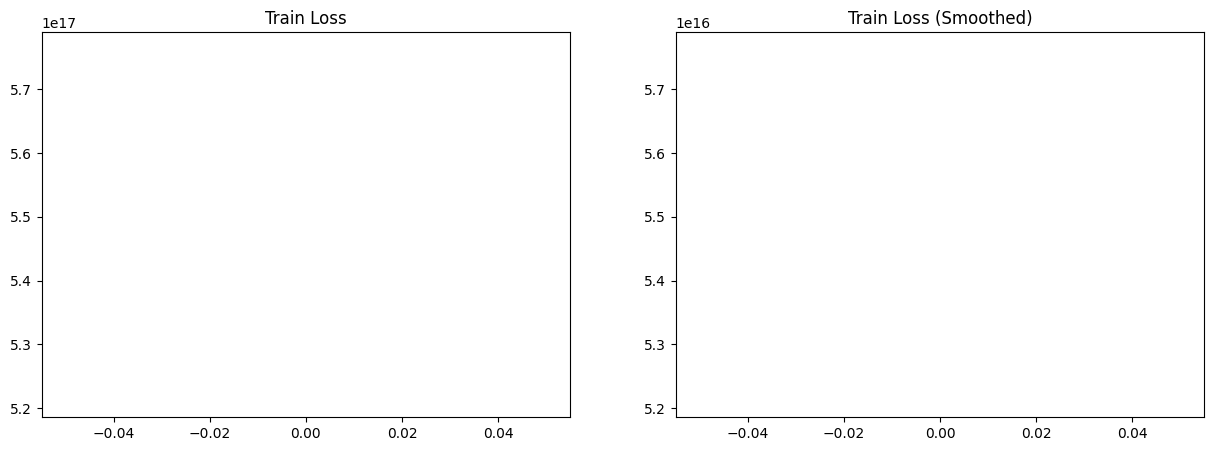

1/1 [==============================] - 0s 68ms/step


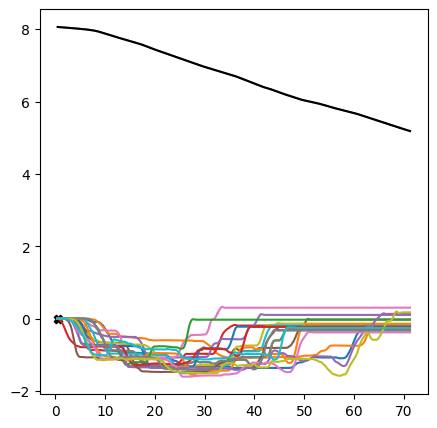

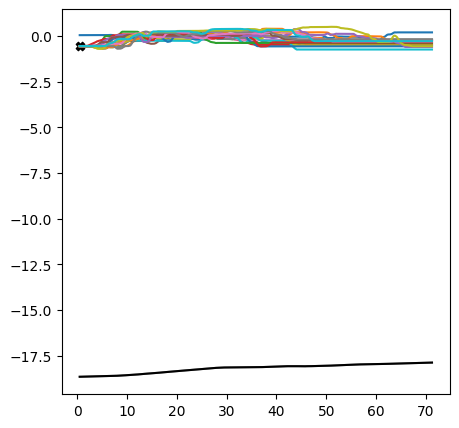

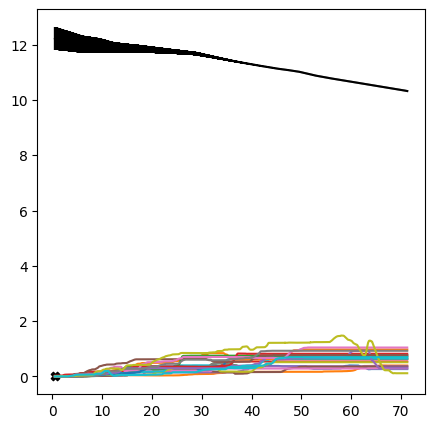

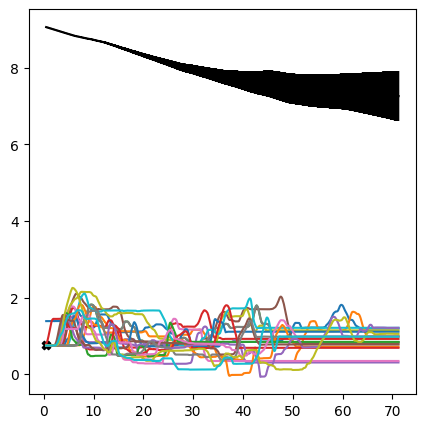

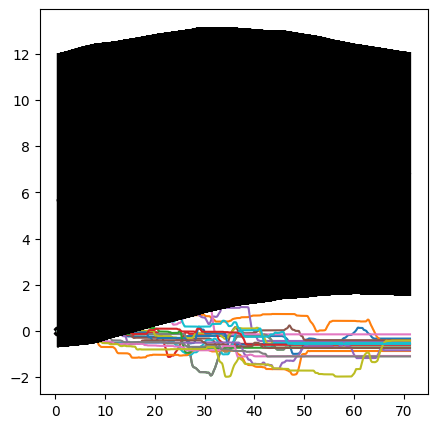

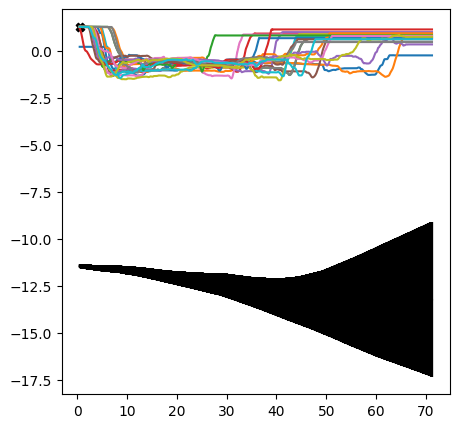

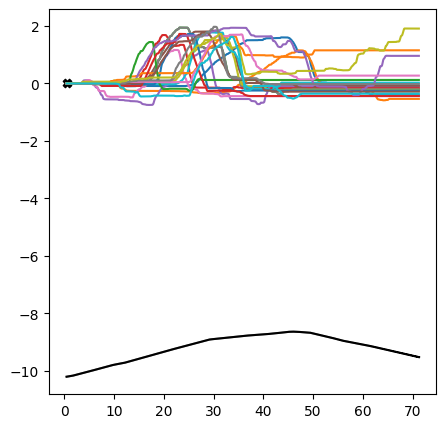

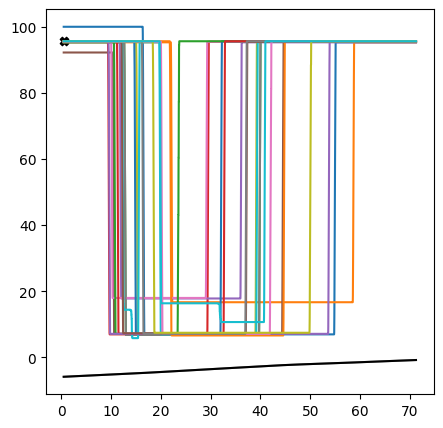

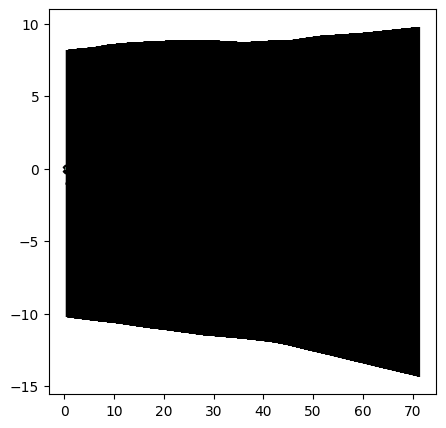

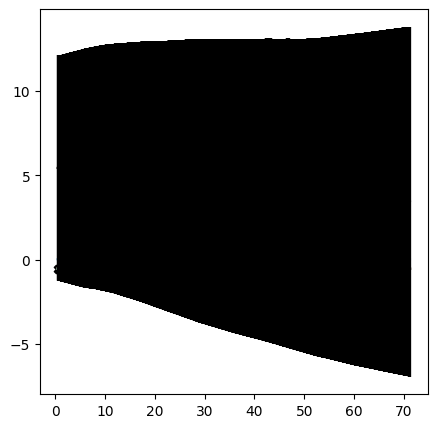

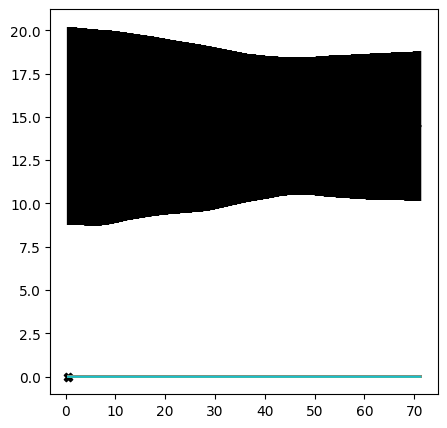

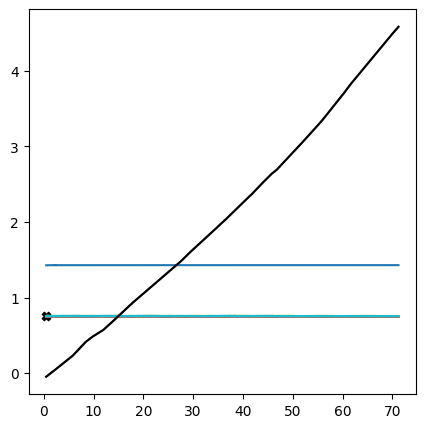

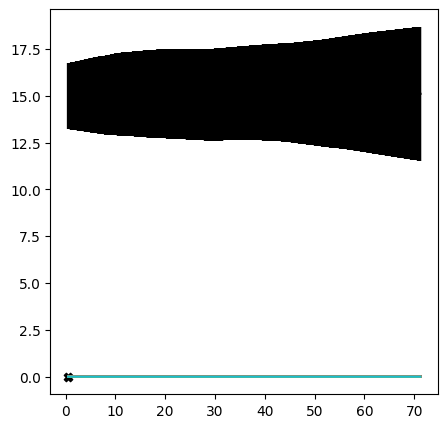

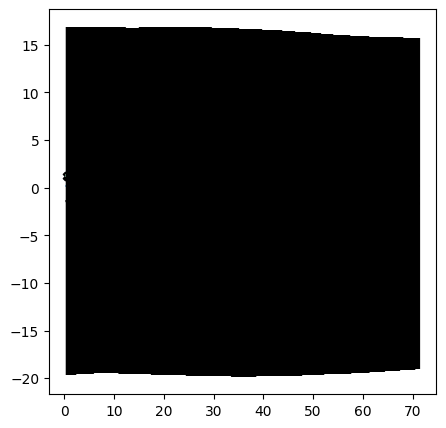

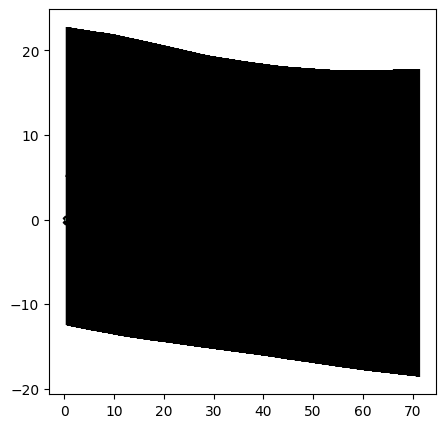

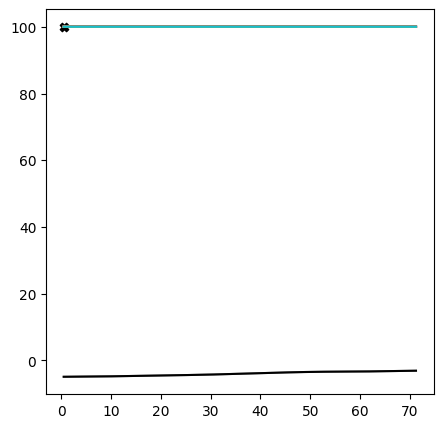

1/1 [==============================] - 0s 53ms/step


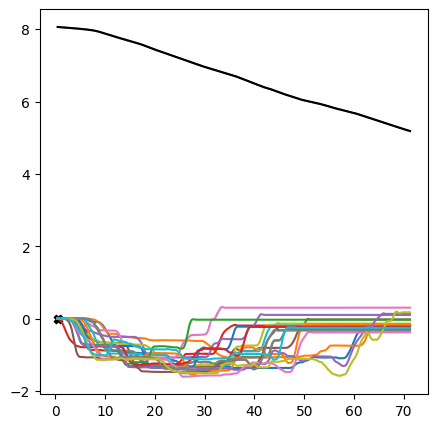

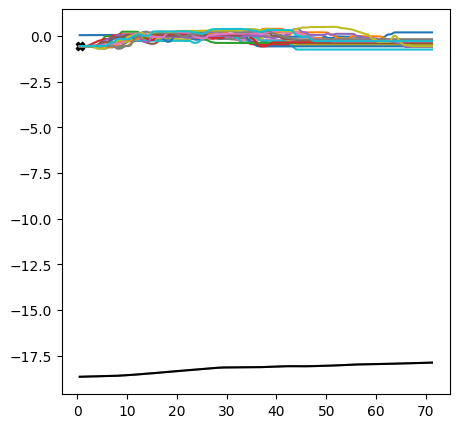

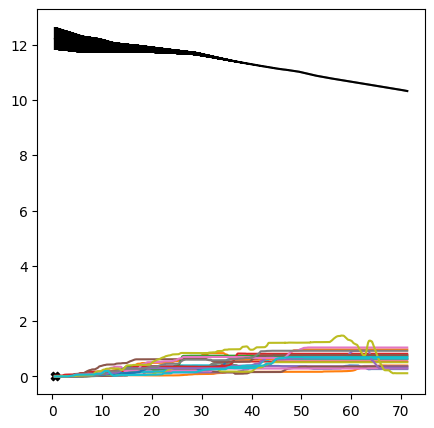

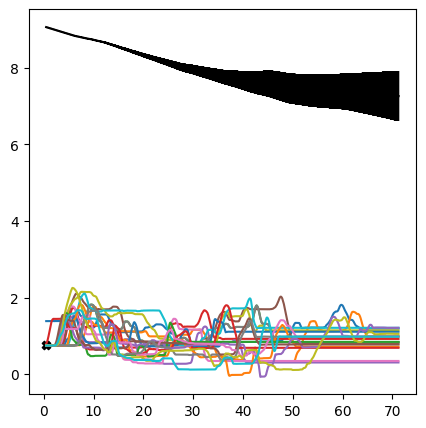

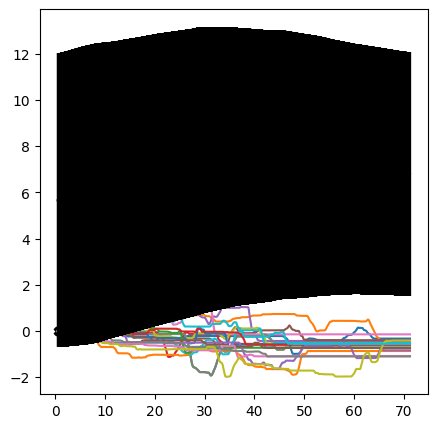

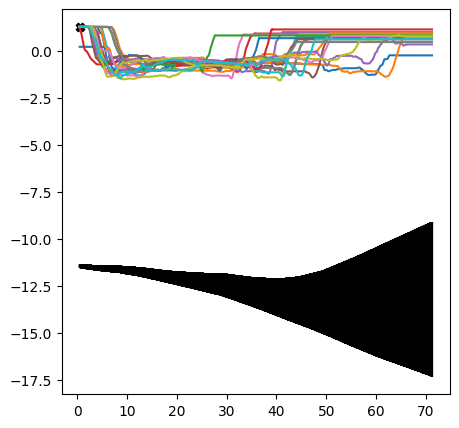

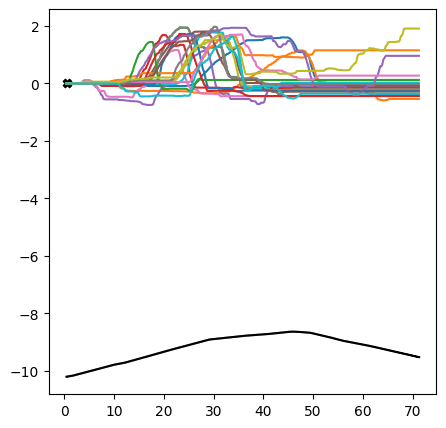

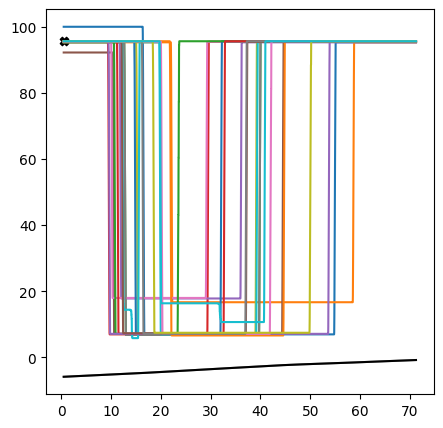

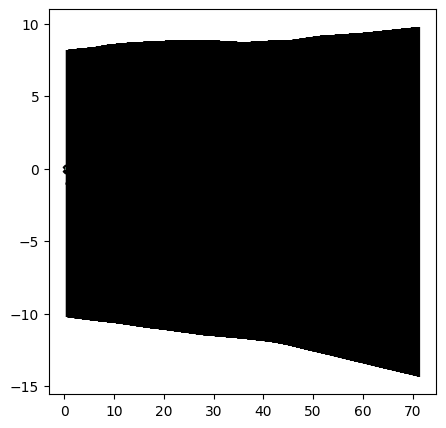

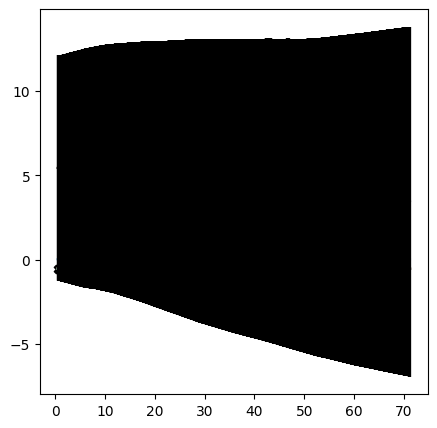

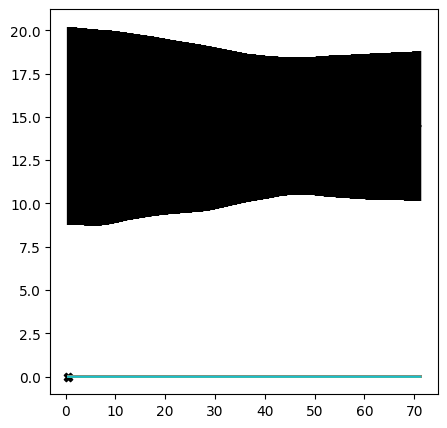

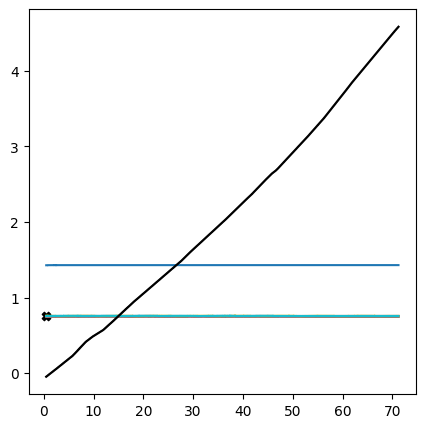

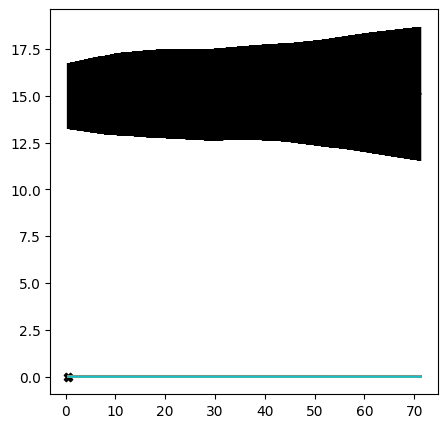

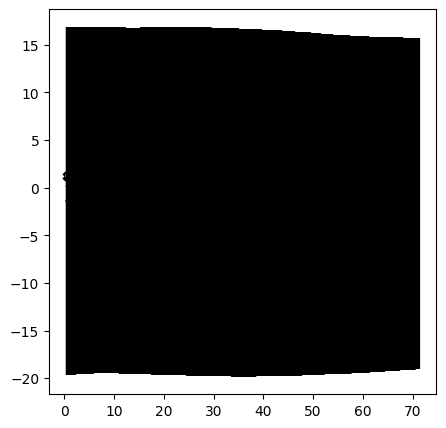

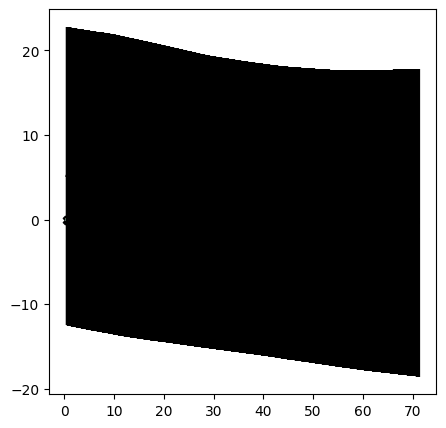

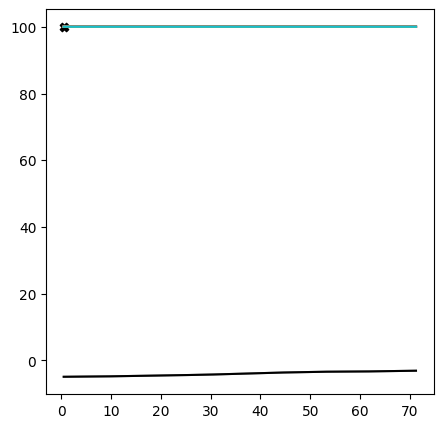

1/1 [==============================] - 0s 53ms/step


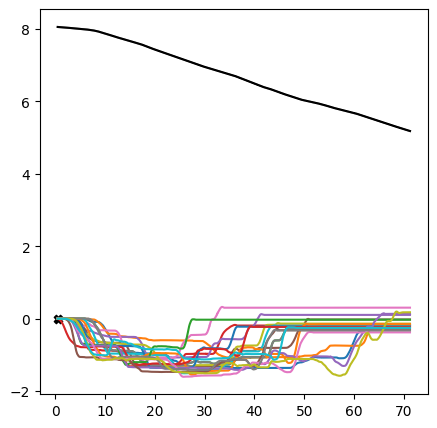

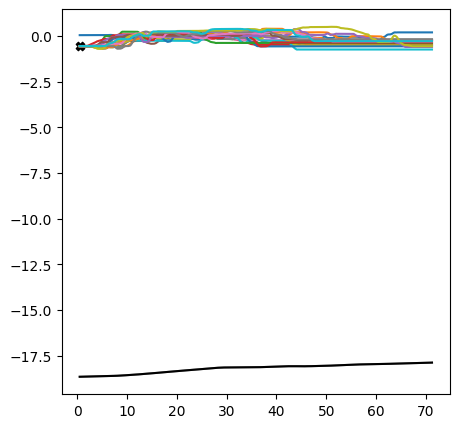

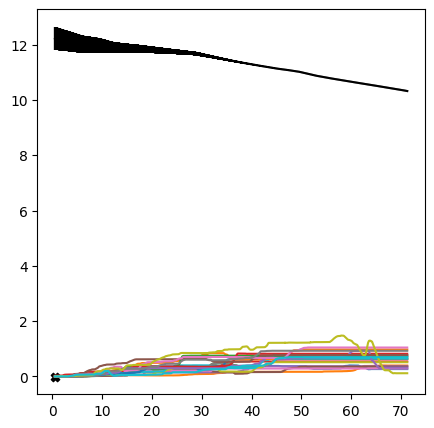

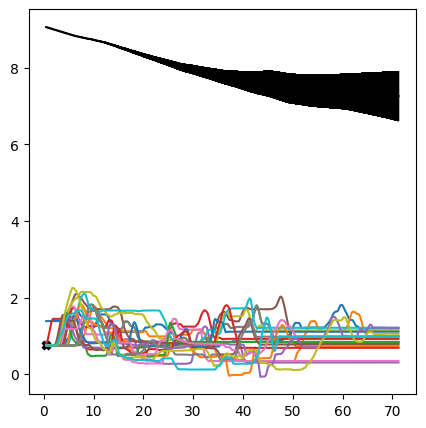

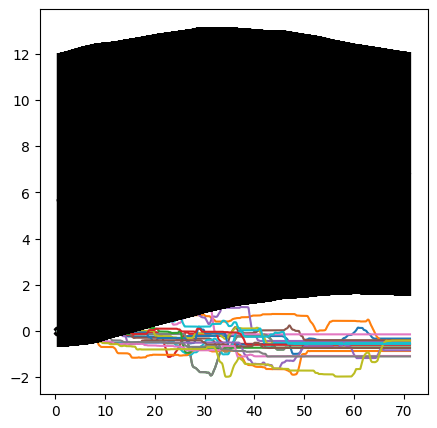

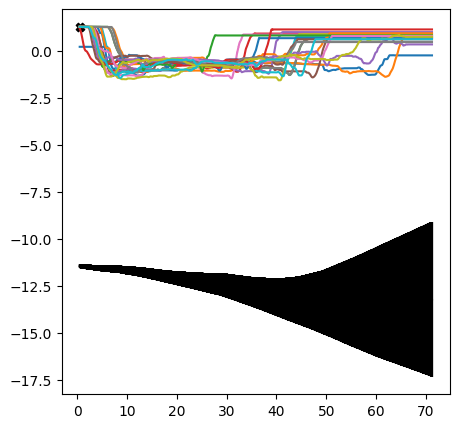

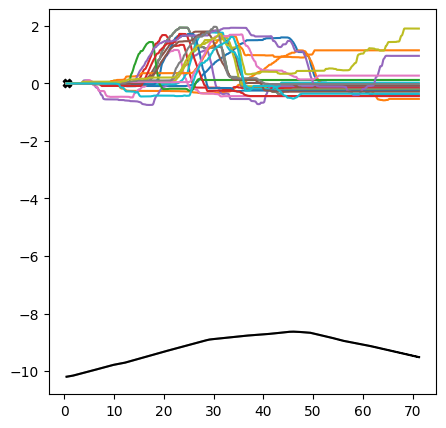

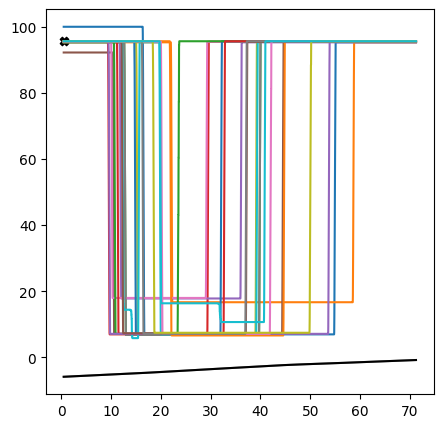

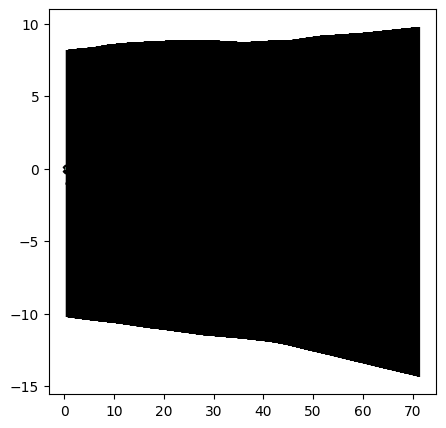

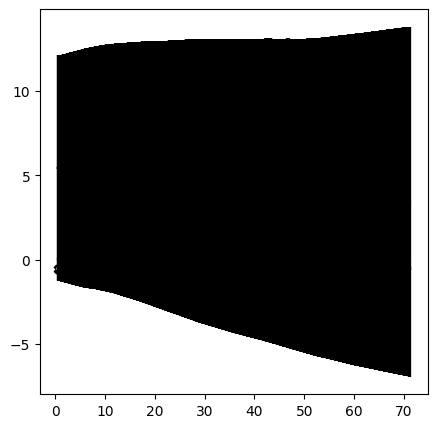

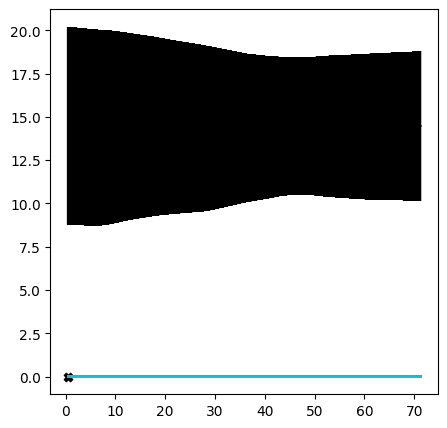

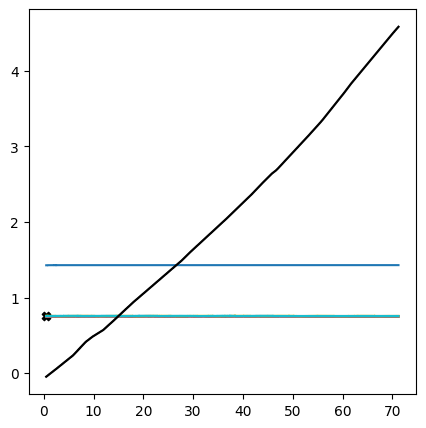

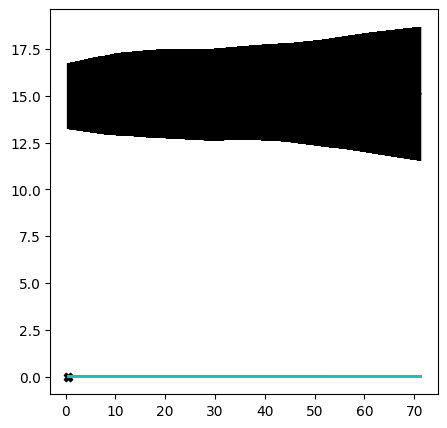

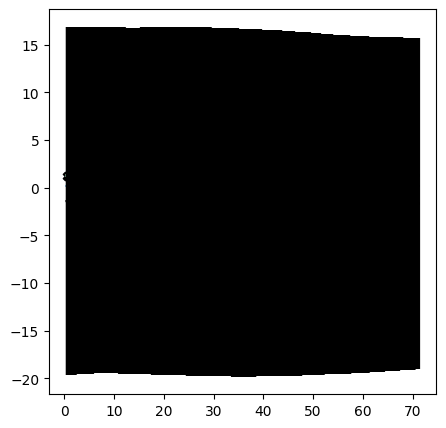

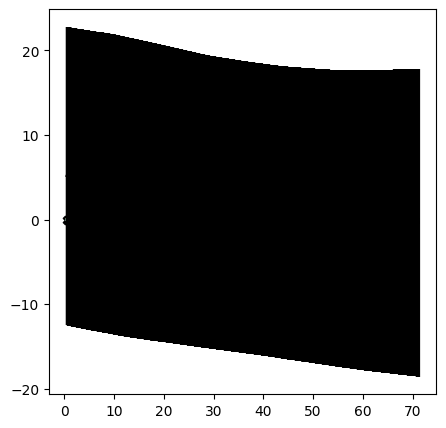

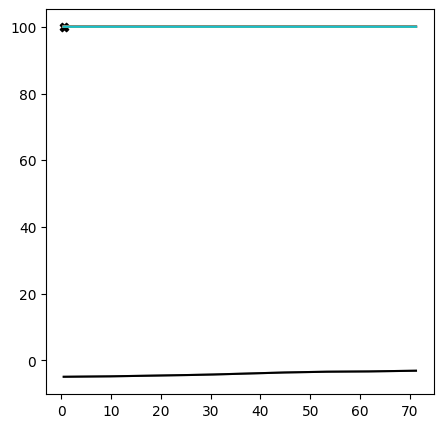

1/1 [==============================] - 0s 100ms/step


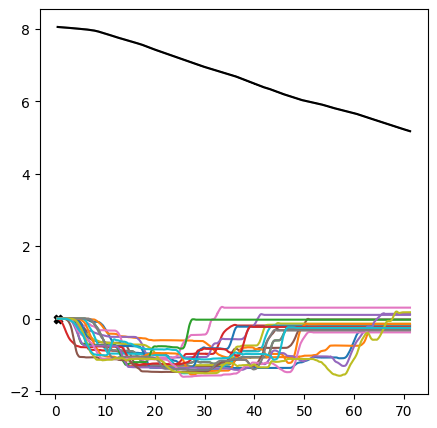

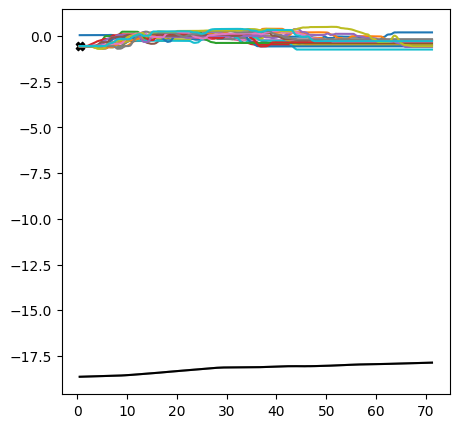

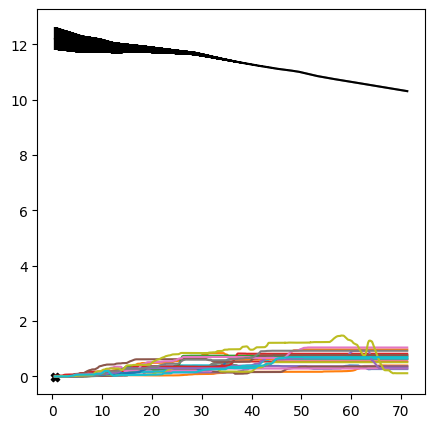

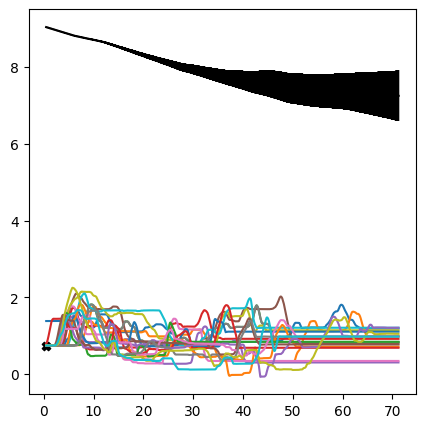

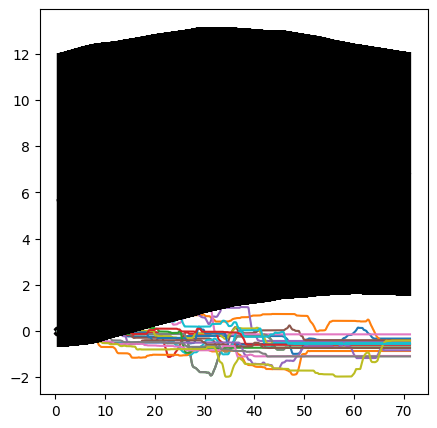

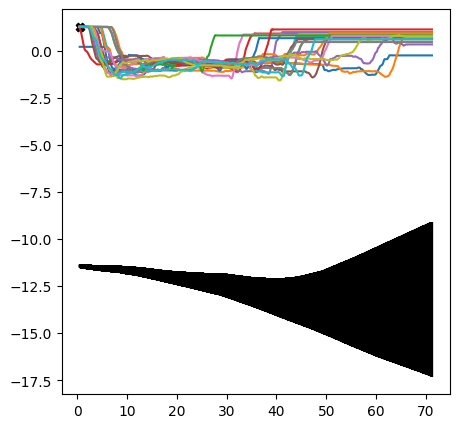

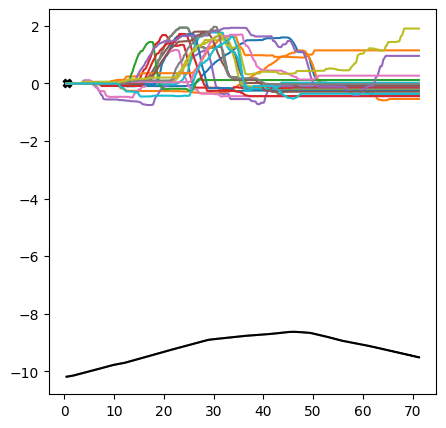

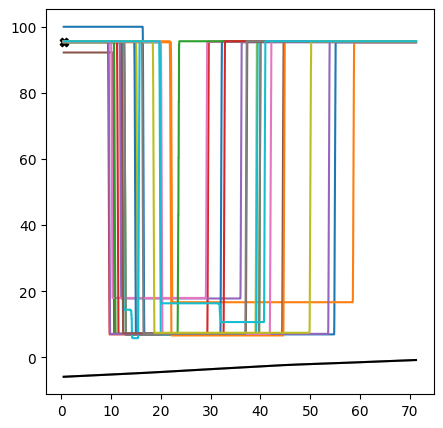

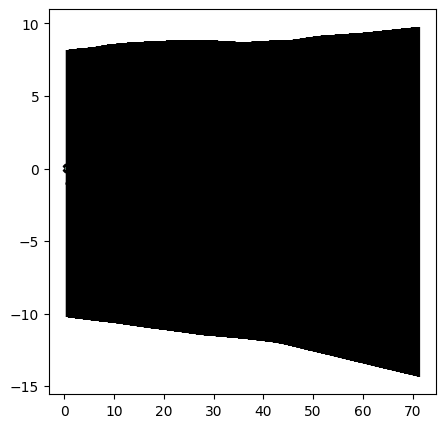

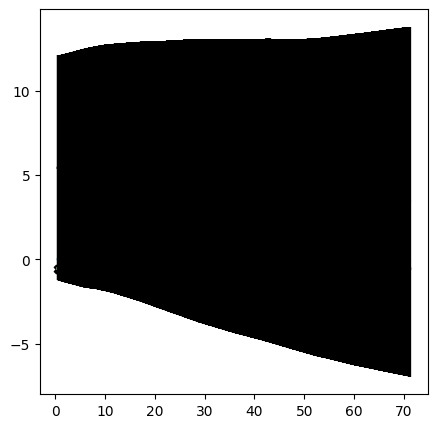

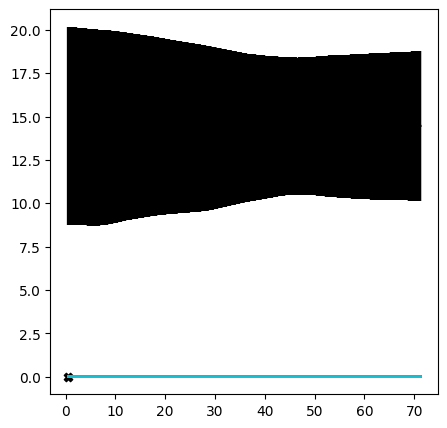

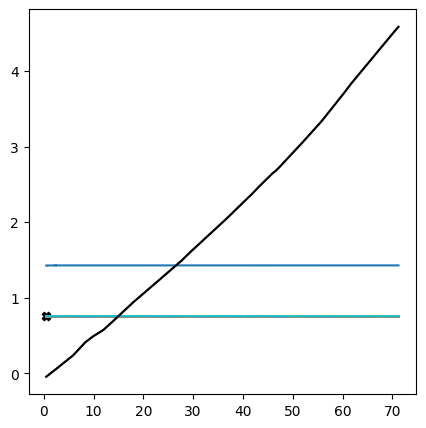

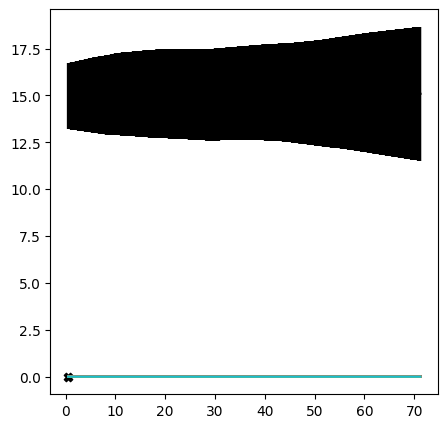

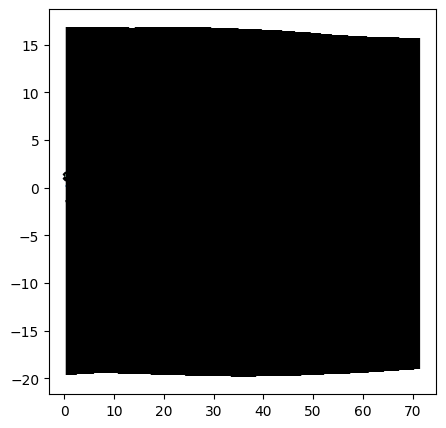

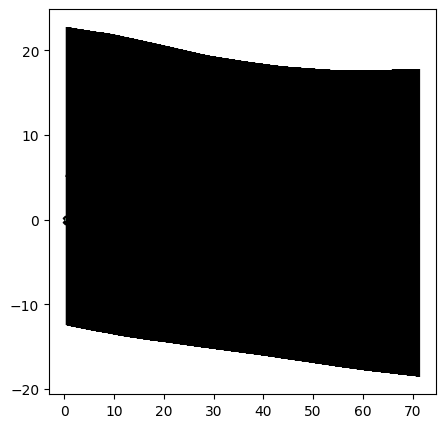

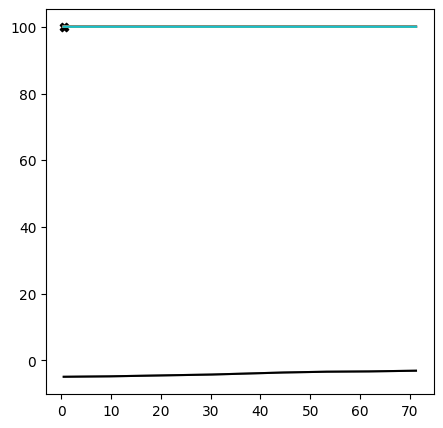

1/1 [==============================] - 0s 42ms/step


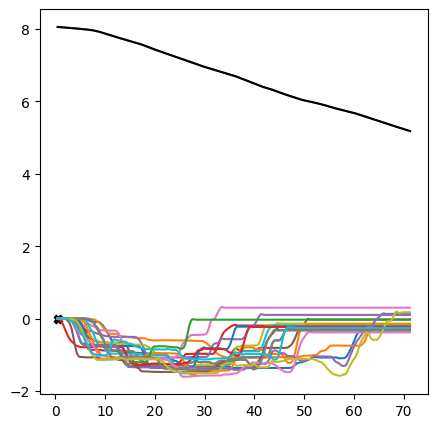

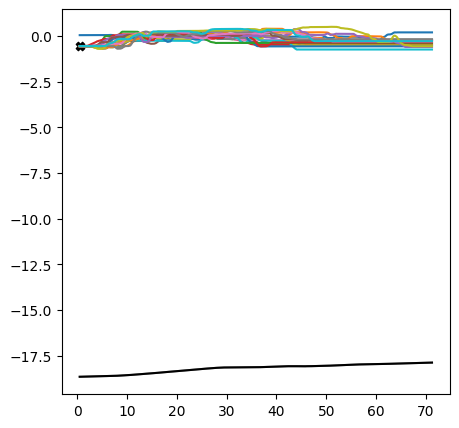

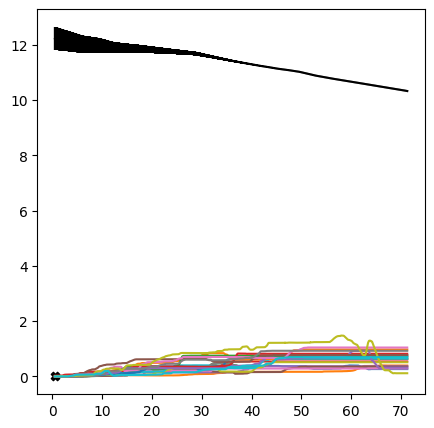

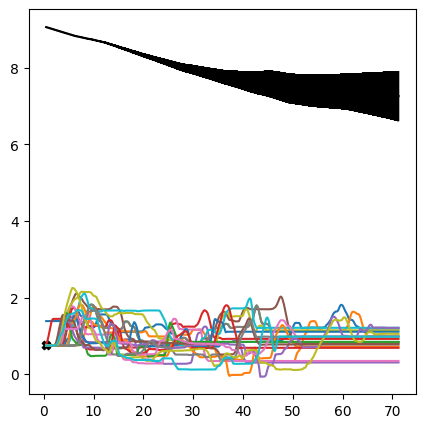

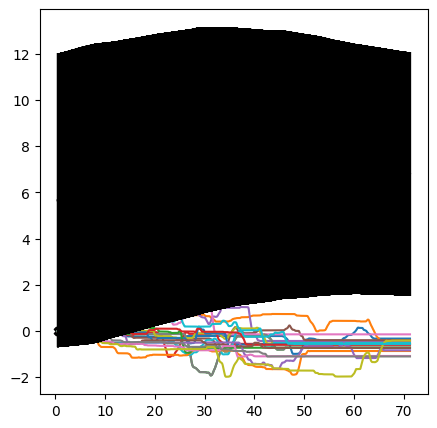

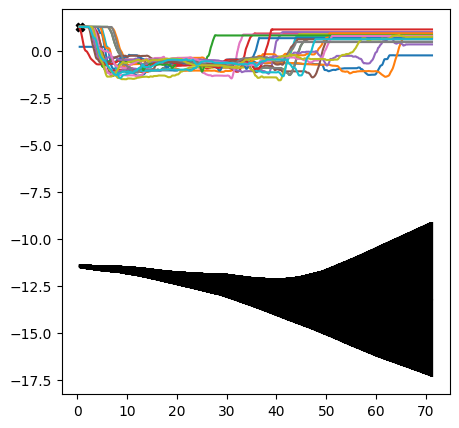

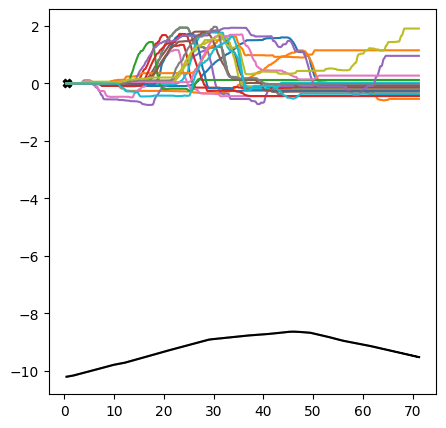

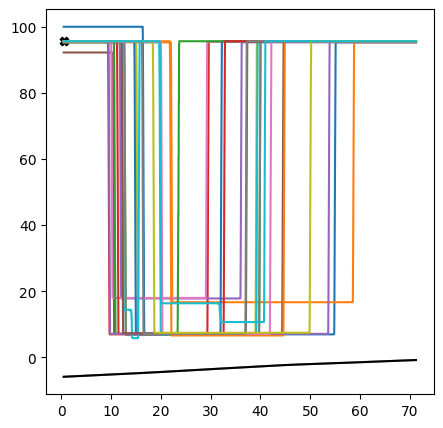

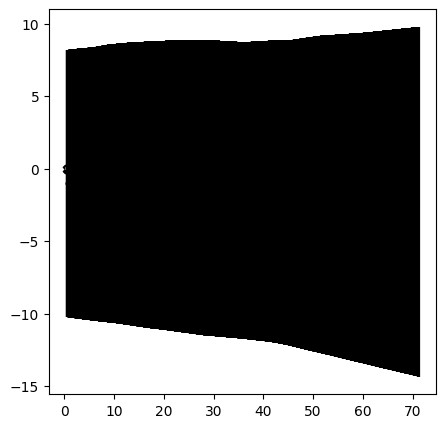

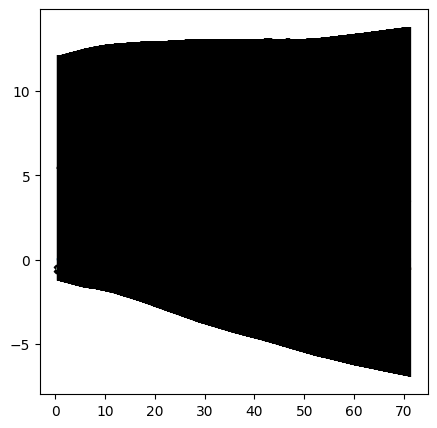

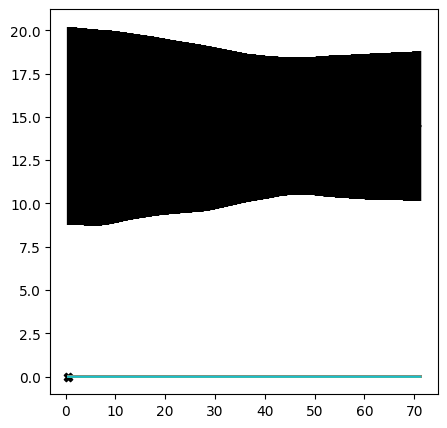

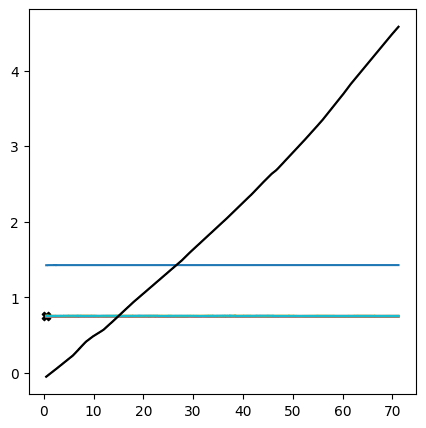

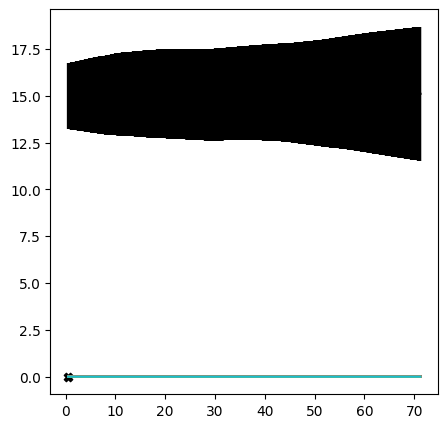

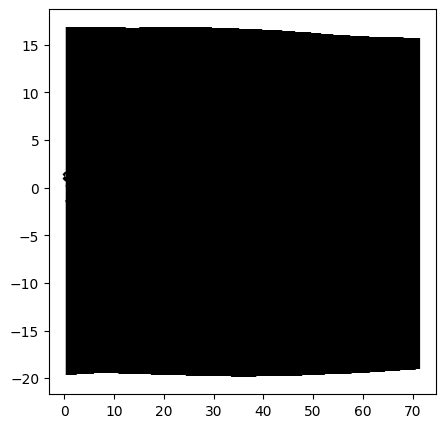

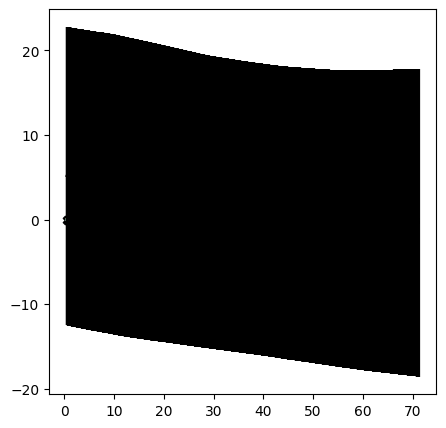

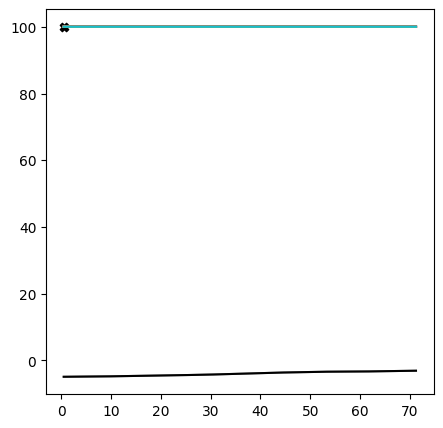

1/1 [==============================] - 0s 63ms/step


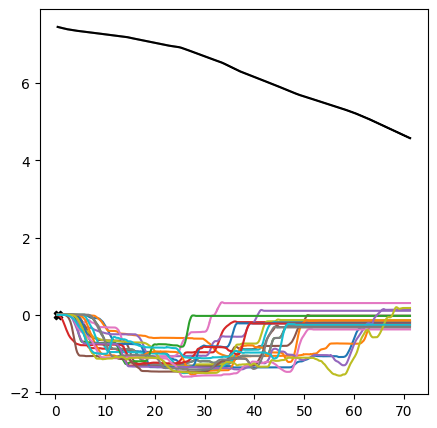

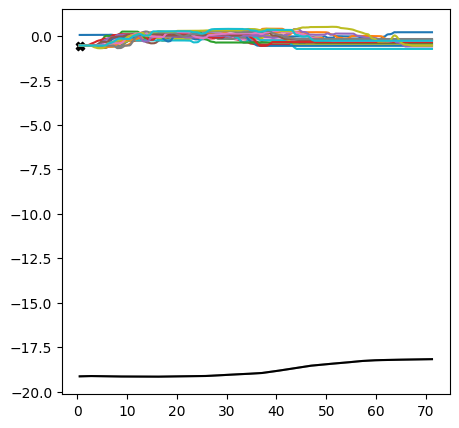

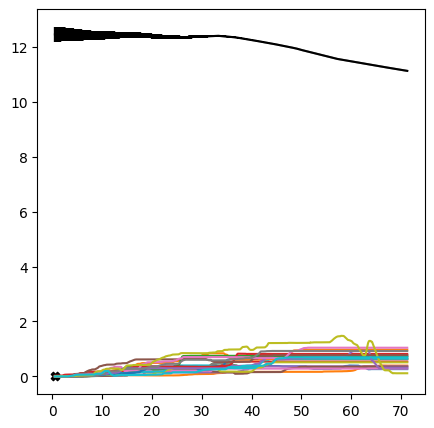

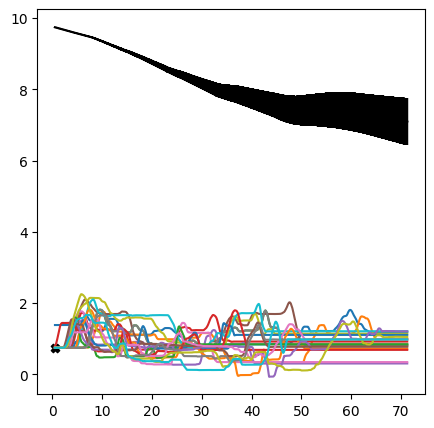

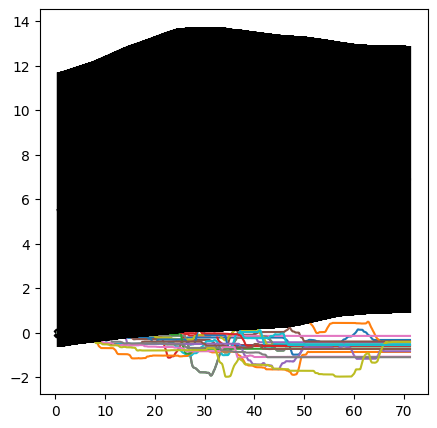

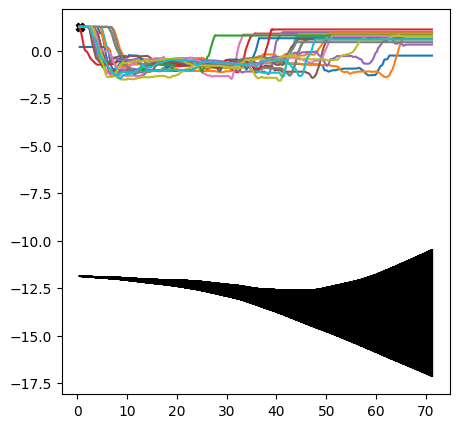

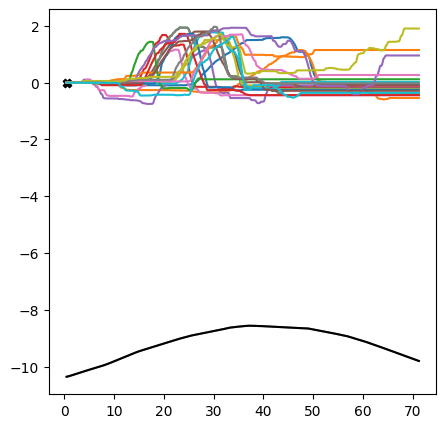

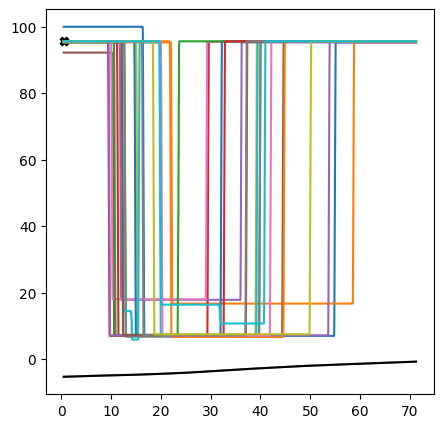

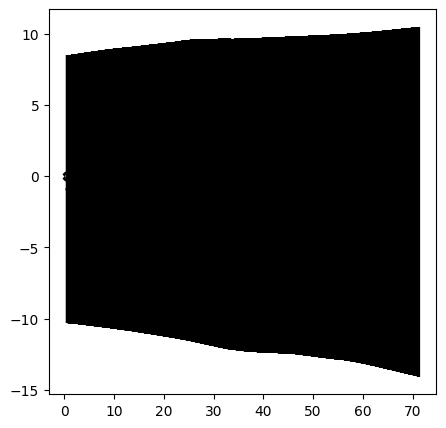

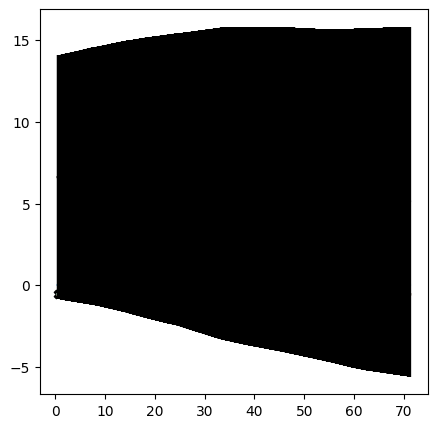

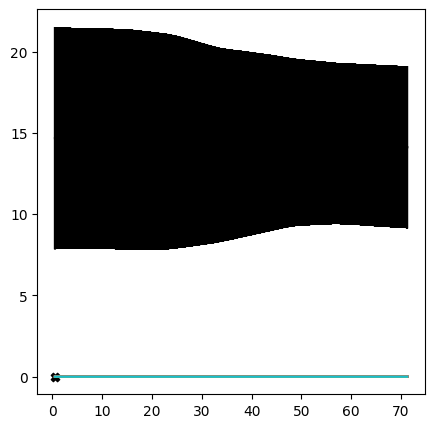

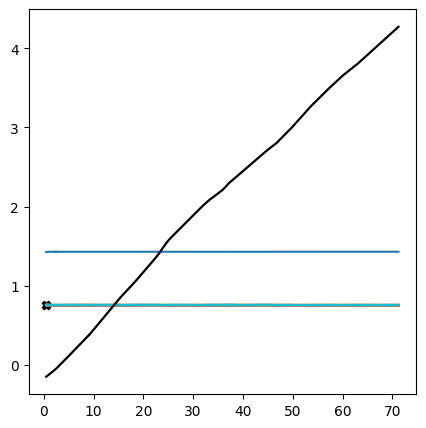

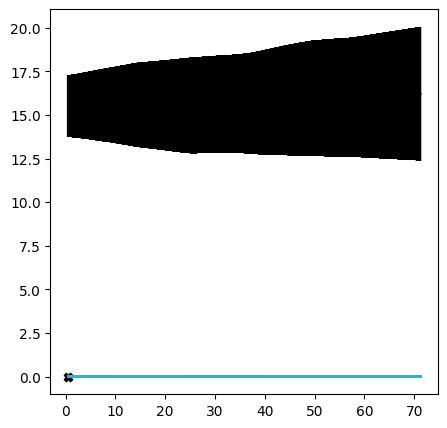

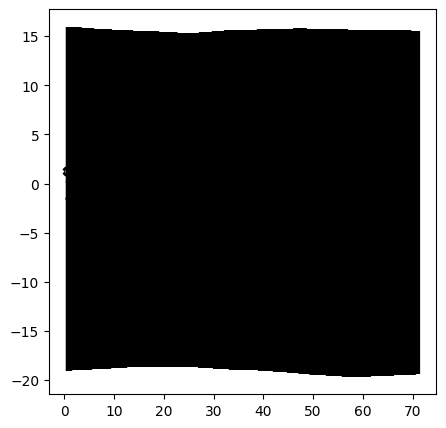

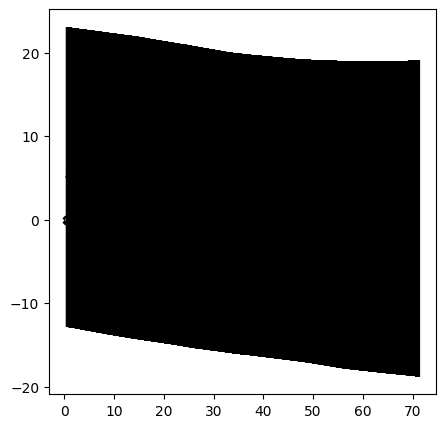

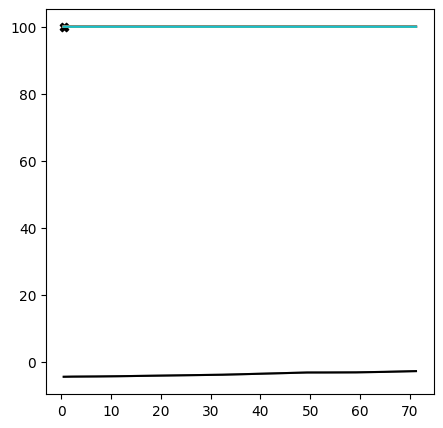

1/1 [==============================] - 0s 60ms/step


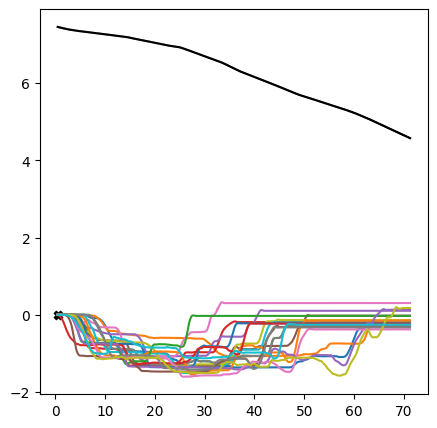

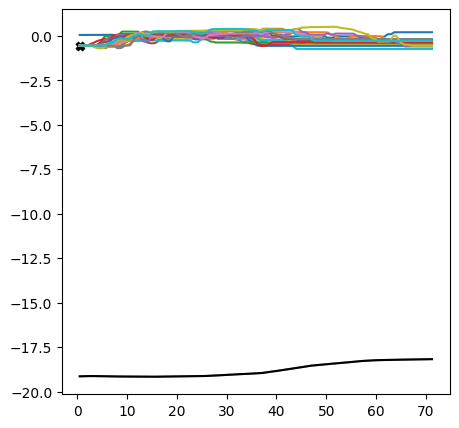

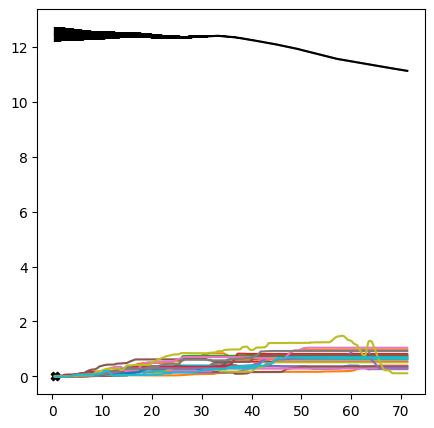

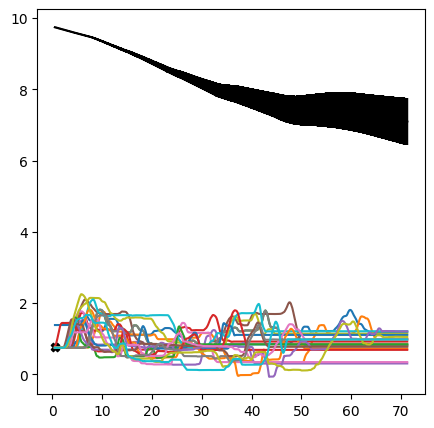

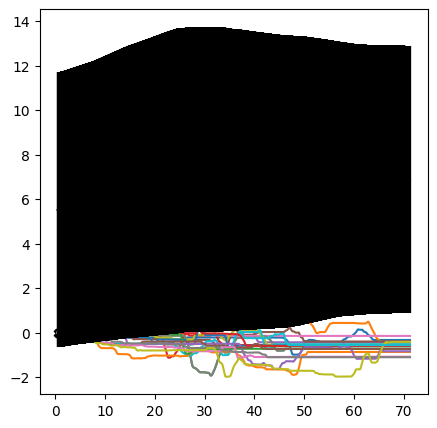

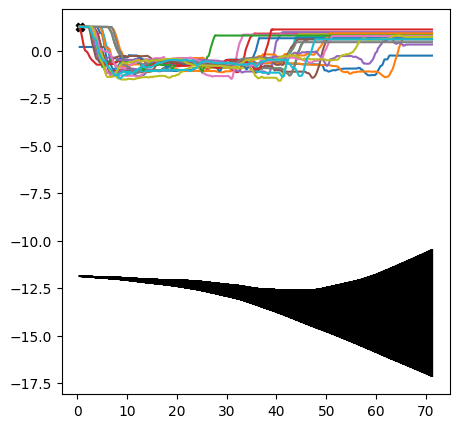

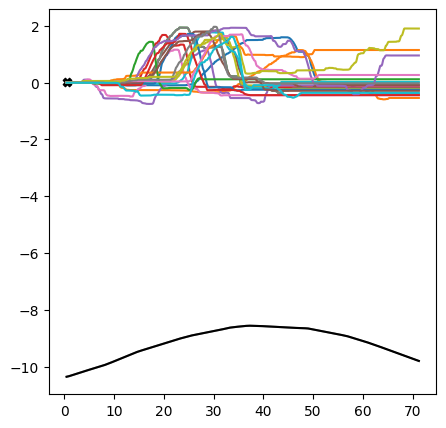

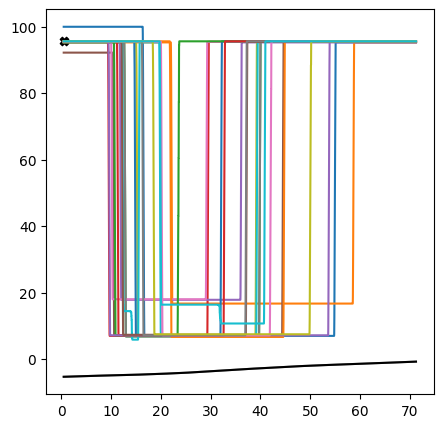

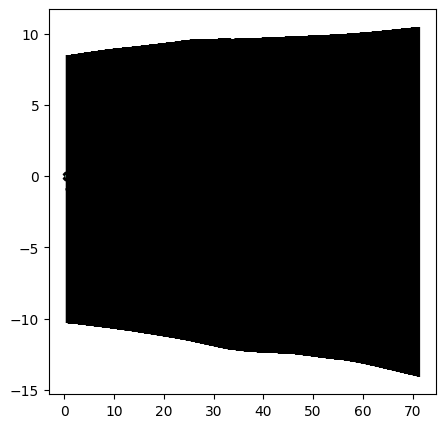

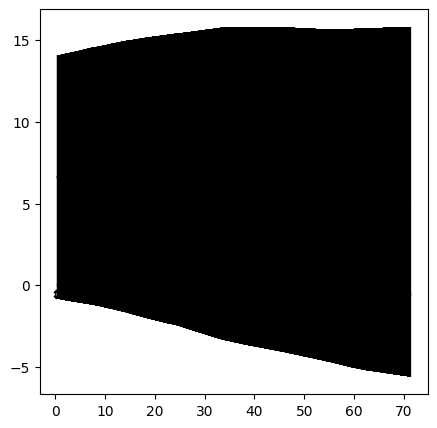

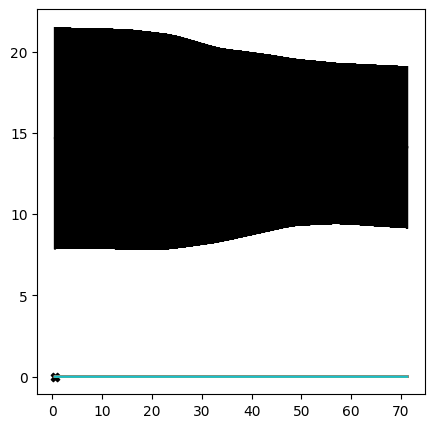

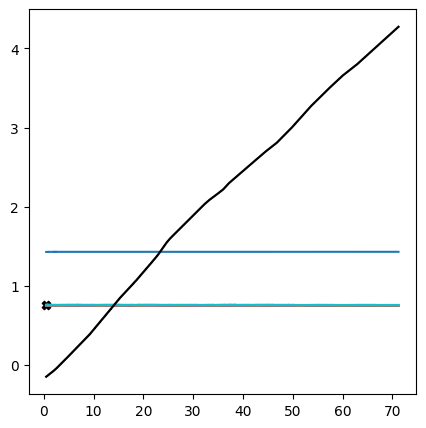

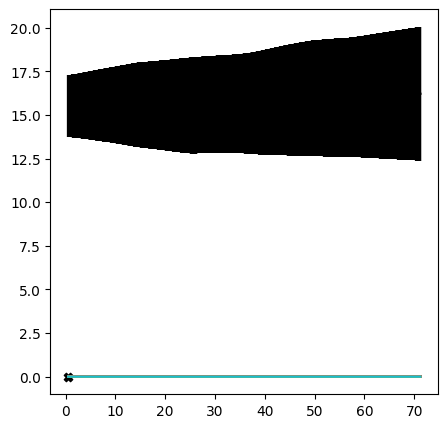

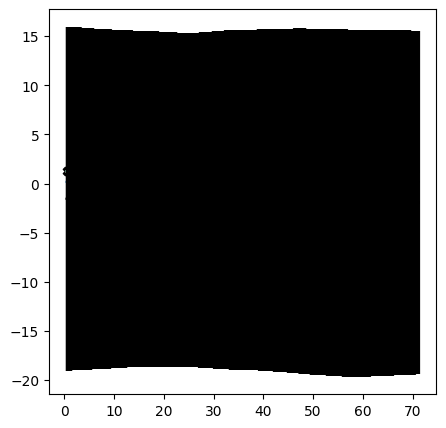

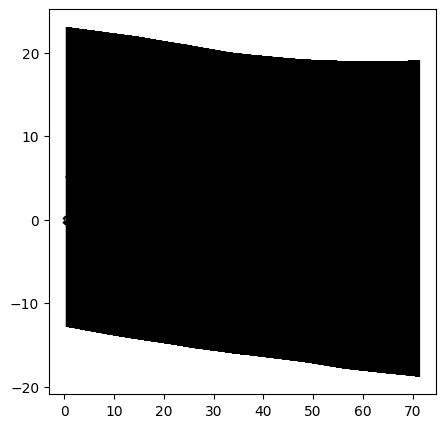

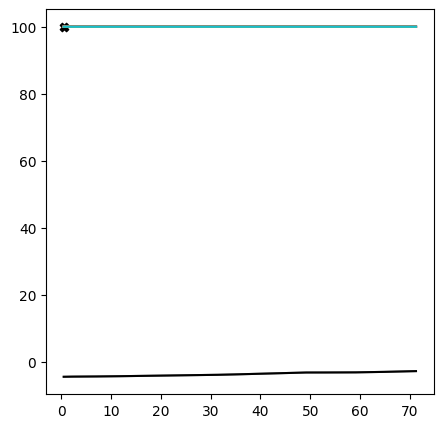

1/1 [==============================] - 0s 47ms/step


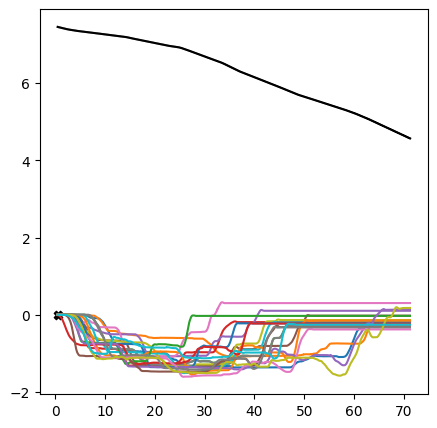

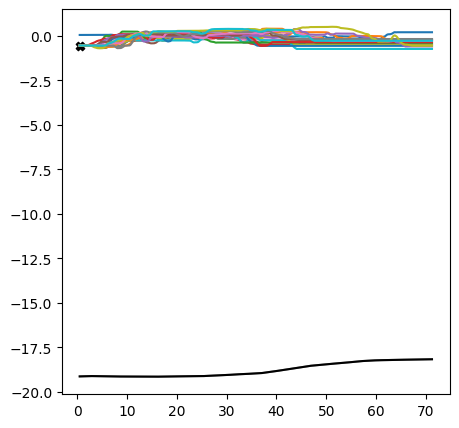

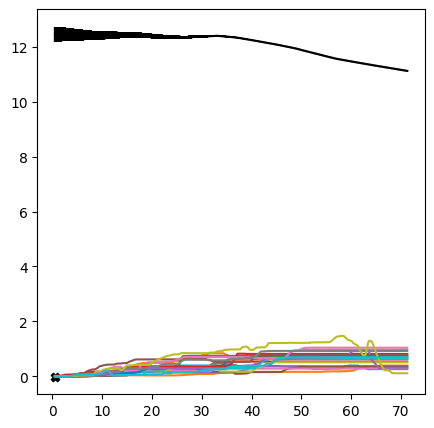

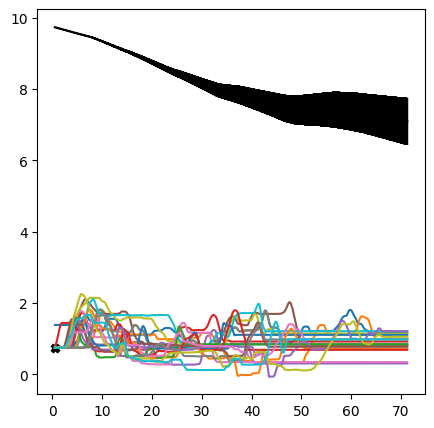

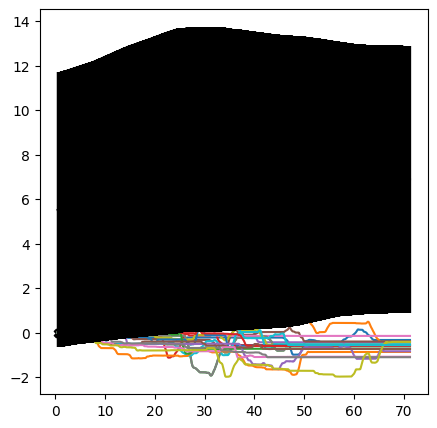

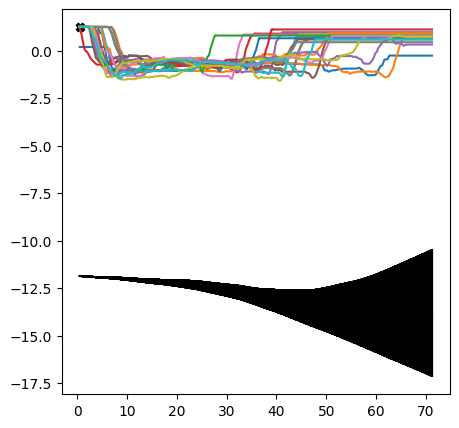

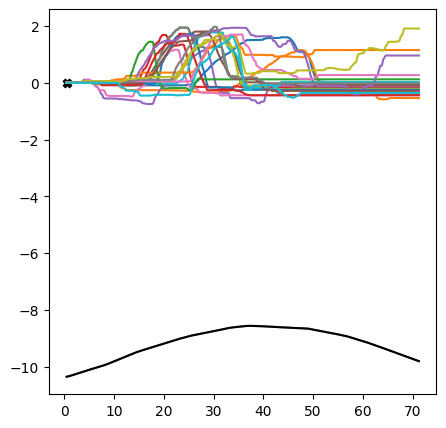

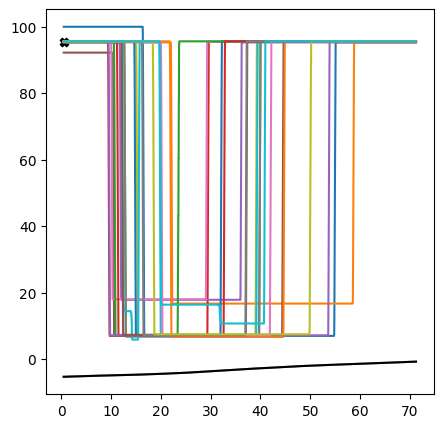

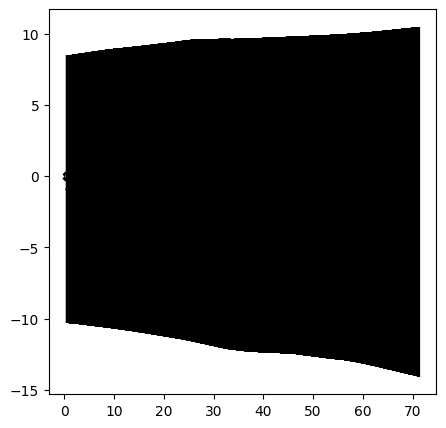

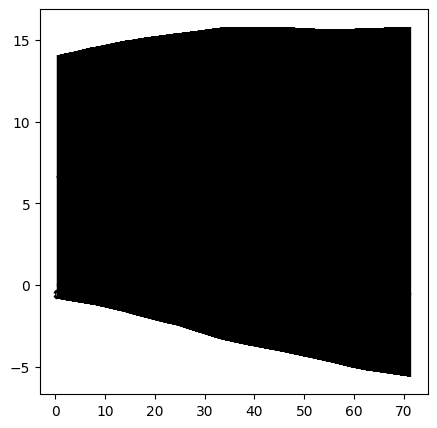

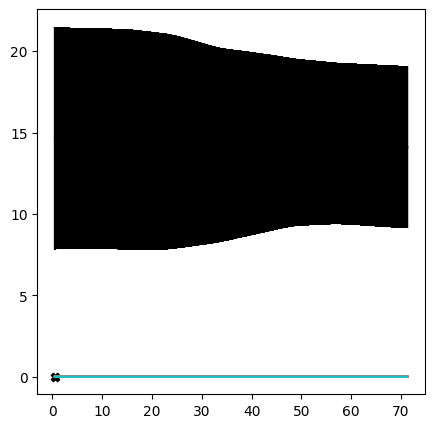

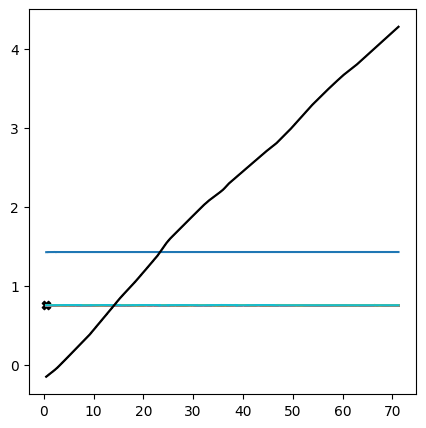

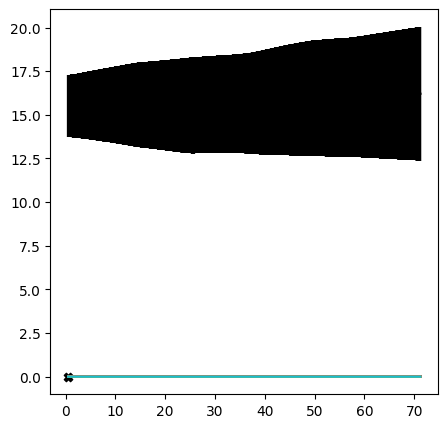

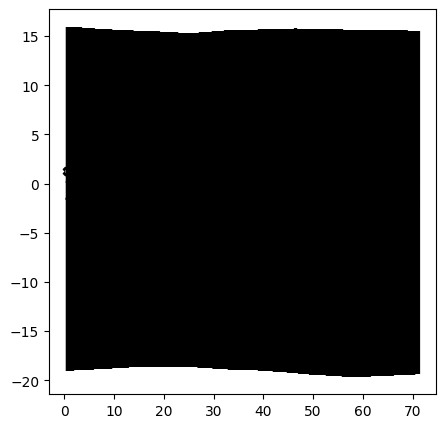

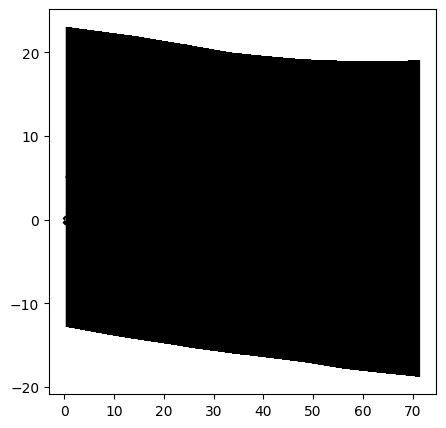

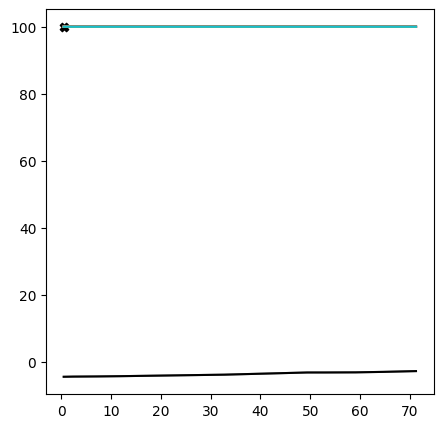

1/1 [==============================] - 0s 73ms/step


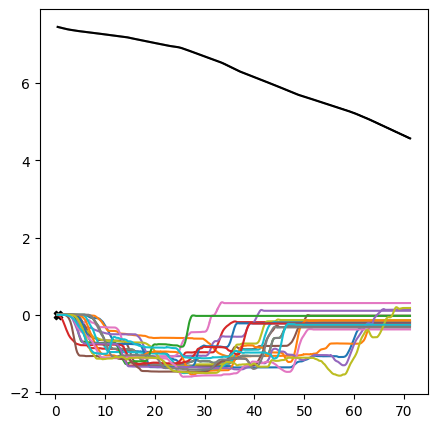

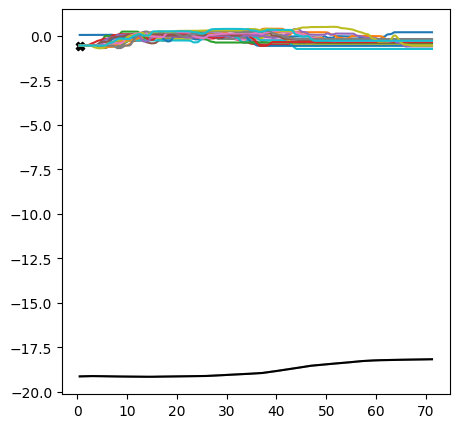

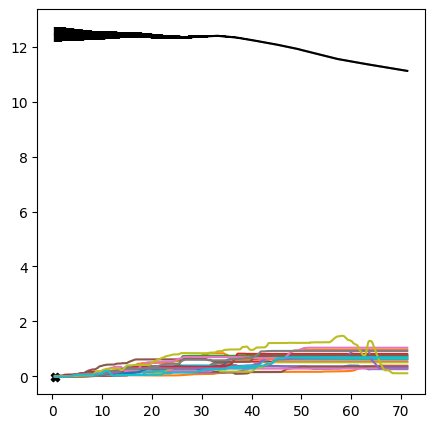

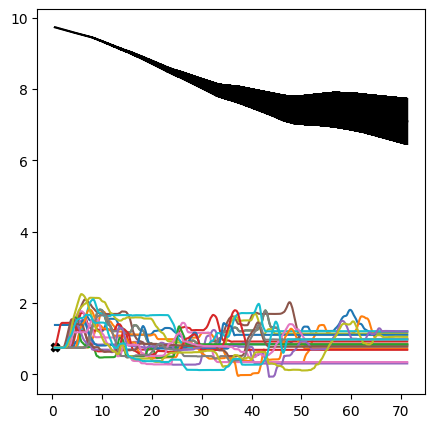

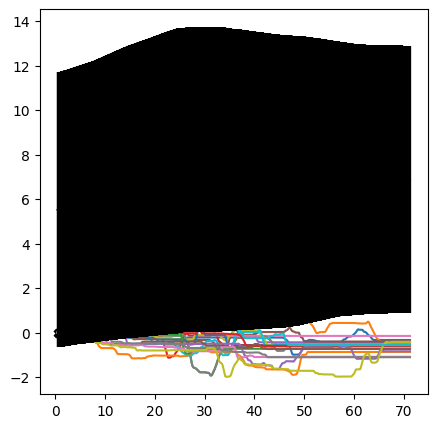

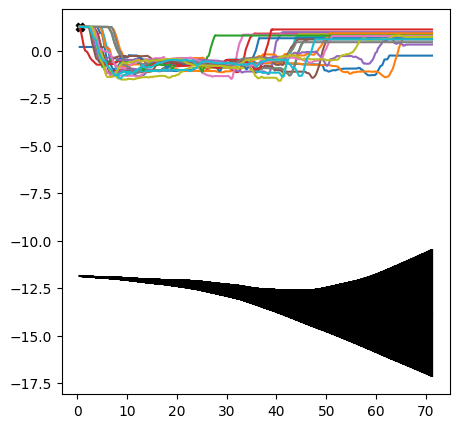

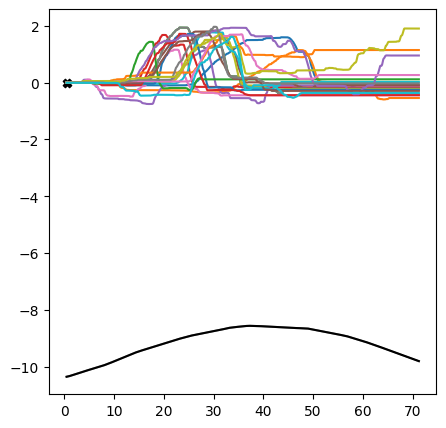

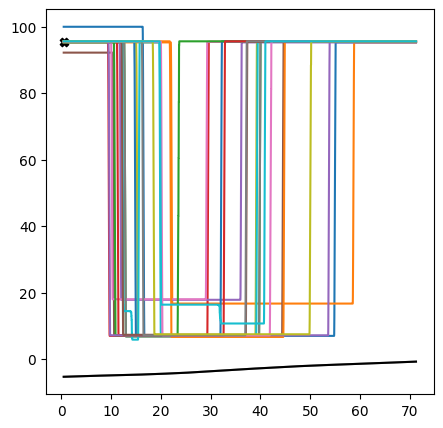

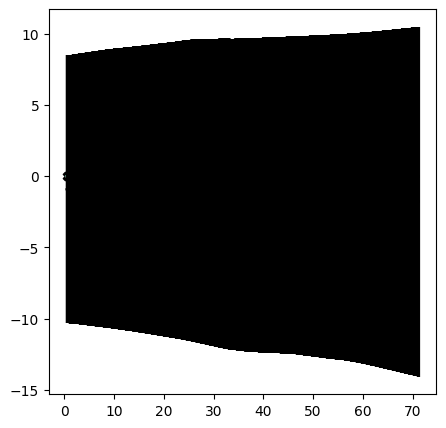

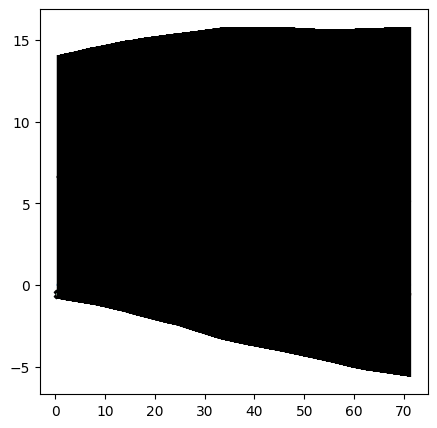

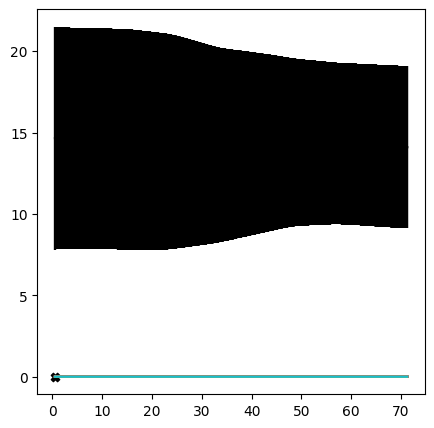

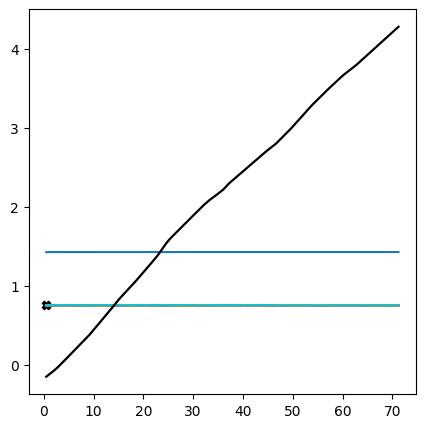

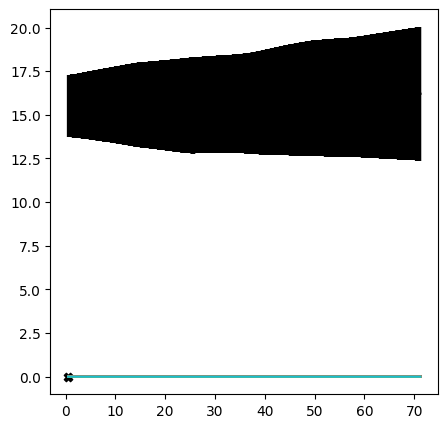

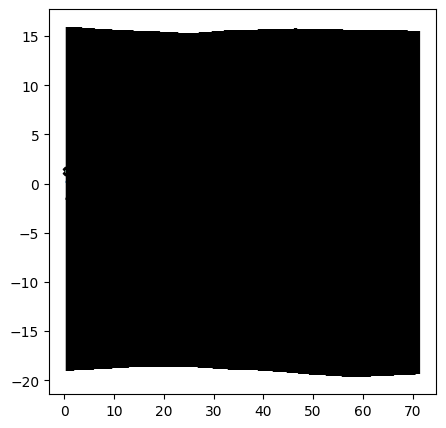

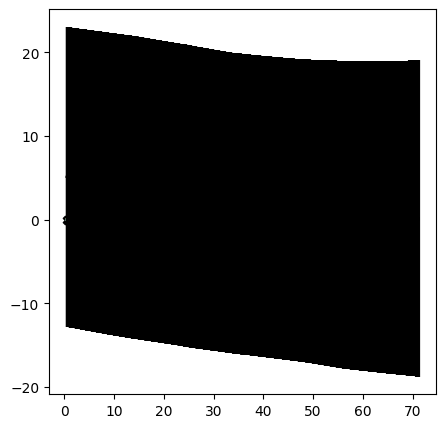

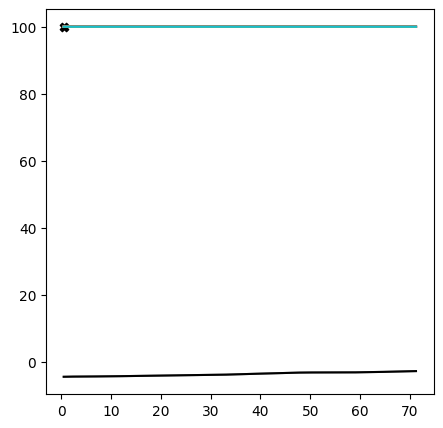

1/1 [==============================] - 0s 82ms/step


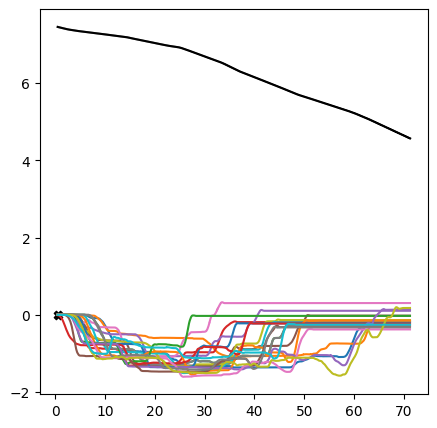

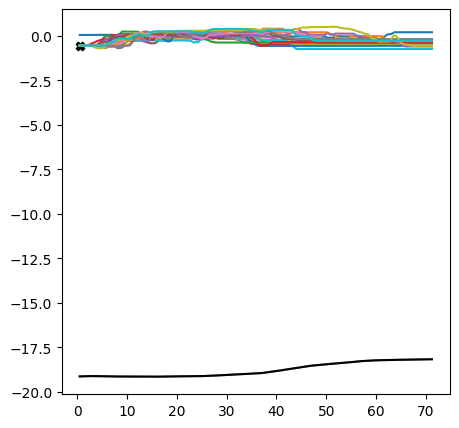

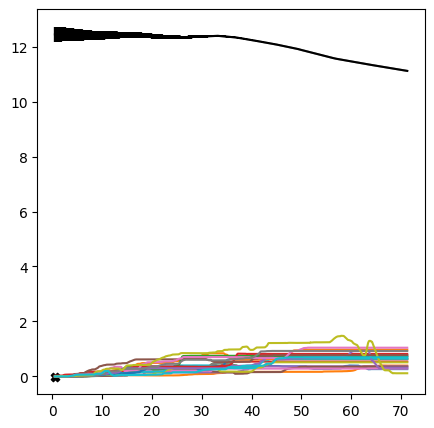

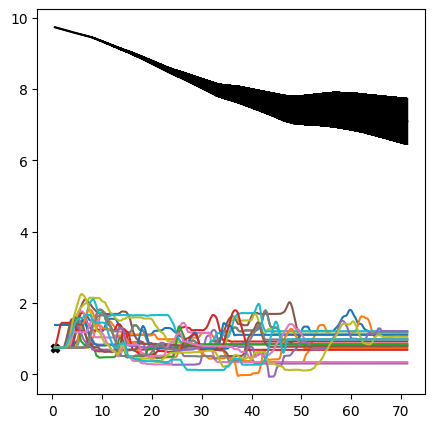

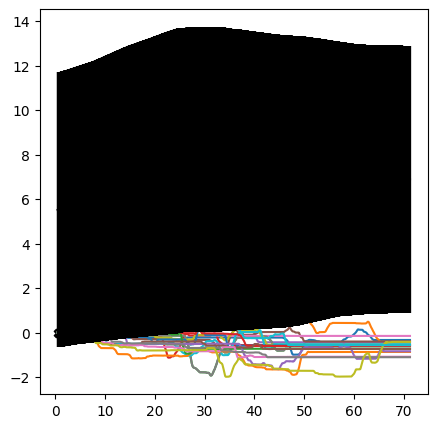

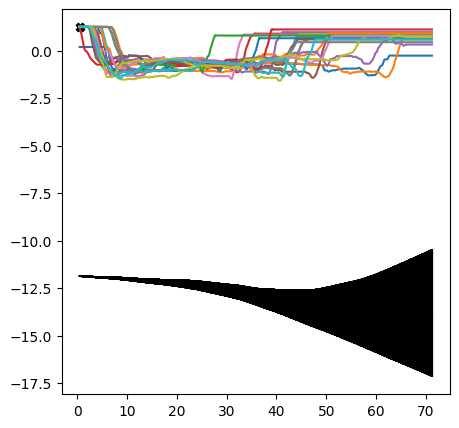

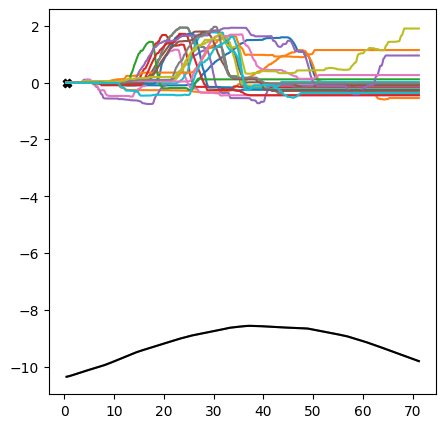

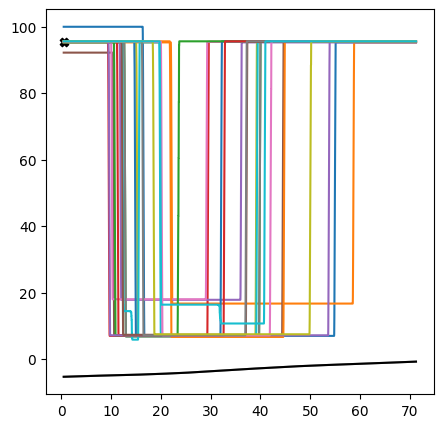

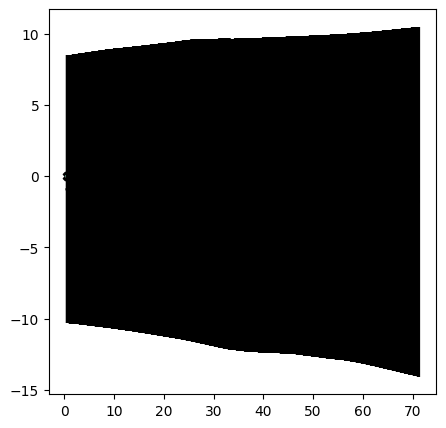

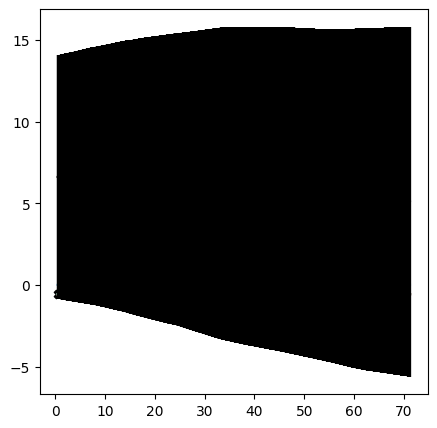

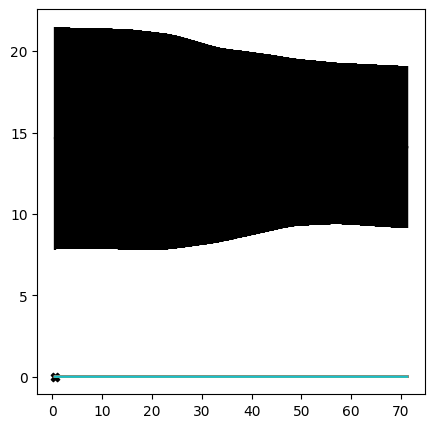

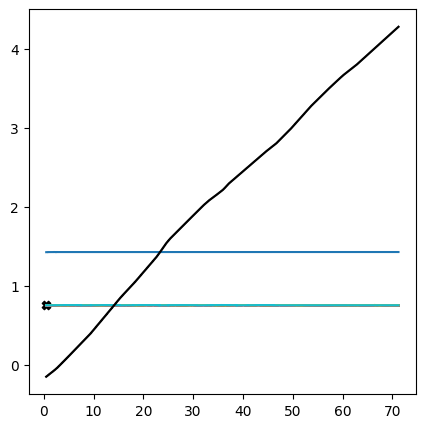

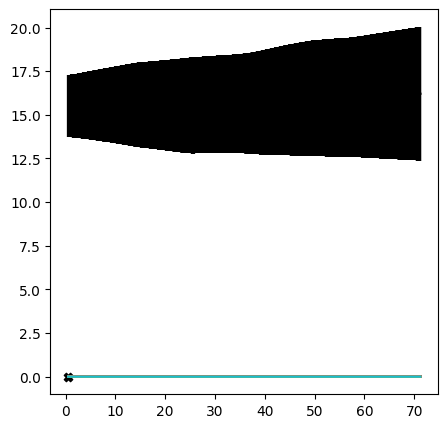

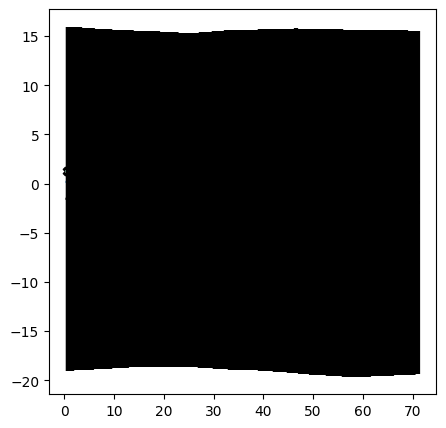

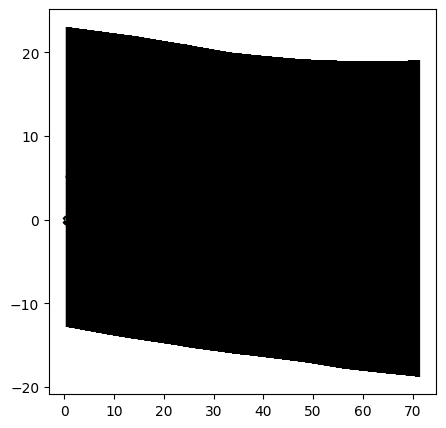

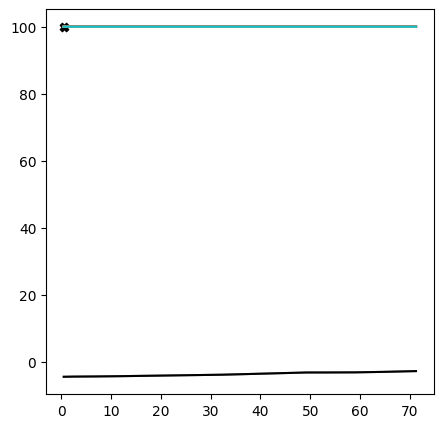

   7810/1000000 [..............................] - ETA: 6:39:57 - loss: nan

KeyboardInterrupt: 

In [25]:
max_training_step = 1000000
model.fit_generator(generator(), steps_per_epoch=max_training_step, epochs=1, verbose=1, callbacks=[CNMP_Callback()])

In[ ]:

In [ ]:
Y = np.pad(Y, ((0, 0), (0, 0), (0, 2)), mode='constant')

### Loading the Best Model 

In[63]:

In [ ]:
import keras.losses
keras.losses.custom_loss = custom_loss

In [ ]:
model = load_model('cnmp_best_validation.h5', custom_objects={ 'tf':tf })

### Testing the Model

In[65]:

In [ ]:
predicted_Y,predicted_std = predict_model(np.concatenate(([[0.8]],[[-0.38]]), axis=1).reshape(1,-1,d_x+d_y), X[0].reshape(1,time_len,d_x))

In [ ]:
predicted_Y

In[40]: